In [5]:
!pip install --upgrade catboost
!pip install --upgrade optuna
!pip install --upgrade lightgbm
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 587.9 kB/s eta 0:00:0000:0100:01


In [6]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import warnings
warnings.filterwarnings("ignore")

import optuna
from optuna.samplers import TPESampler
# import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import os, sys

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# print(os.getcwd())

/content


In [ ]:
# os.chdir('/content/drive/MyDrive/colab/flood-prediction')

In [7]:
os.getcwd()

'/media/pranit/769A7EDE9A7E9A77/PP - Learning Stuff/competitions/kaggle competitions/flood-prediction'

In [8]:
os.listdir()

['.git',
 'catboost_info',
 'data',
 'flood_prediction fengine.ipynb',
 'flood_prediction.ipynb',
 'flood_prediction_CB_scaling.ipynb',
 'Pranit_S4E5_submission.csv',
 'Pranit_S4E5_submission_feature_engg.csv',
 'S4E5_submission_feature_engg_CB.csv',
 'S4E5_submission_feature_engg_XGB.csv']

In [9]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_test_ov = df_test.copy()
df_orig = pd.read_csv("./data/og.csv")

In [10]:
df_train.head()

id  MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0   0                 5                   8                5              8   
1   1                 6                   7                4              4   
2   2                 6                   5                6              7   
3   3                 3                   4                6              5   
4   4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   ...  DrainageSystems  CoastalVulnerability  Landslides  Watersheds  \
0  ...                5                     3           3           5   
1  ...                7                     2           0           3   
2  ...                7                     3           7           5   
3  ...                2                     4           7           4   
4  ...                2                     2           6           6   

   DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0                            4                7            5   
1                            5                3            3   
2                            6                8            2   
3                            4                6            5   
4                            4                1            2   

   InadequatePlanning  PoliticalFactors  FloodProbability  
0                   7                 3             0.445  
1                   4                 3             0.450  
2                   3                 3             0.530  
3                   7                 5             0.535  
4                   3                 5             0.415  

[5 rows x 22 columns]

In [11]:
print(df_train.shape)
print(df_train.columns)

(1117957, 22)
Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [ ]:
print(df_orig.shape)
print(df_orig.columns)
print(df_orig.info())

(50000, 21)
Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   MonsoonIntensity                 50000 non-null  int64  
 1   TopographyDrainage               50000 non-null  int64  
 2   RiverManagement                  50000 non-null  int64  
 3   Deforestation                    50000 non-null  int64  
 4   Urbanization    

In [ ]:
print(df_test.shape)
print(df_test.columns)
print(df_test.info())

(745305, 21)
Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745305 entries, 0 to 745304
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype
---  ------                           --------------   -----
 0   id                               745305 non-null  int64
 1   MonsoonIntensity                 745305 non-null  int64
 2   TopographyDrainage               745305 non-null  int64
 3   RiverManagement                  745305 non-null  int64
 4   Deforestation                    

In [ ]:
df_train.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [ ]:
df_orig.isnull().sum()

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [ ]:
df_test.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
dtype: int64

In [3]:
%%time
df_train.drop(columns=["id"], inplace=True)
df_test_id = df_test["id"]
df_test.drop(columns=["id"], inplace=True)
df_combined = pd.concat([df_train, df_orig],ignore_index=True)

CPU times: user 126 ms, sys: 262 ms, total: 388 ms
Wall time: 633 ms


In [ ]:
df_combined.head()

MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 5                   8                5              8   
1                 6                   7                4              4   
2                 6                   5                6              7   
3                 3                   4                6              5   
4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   Encroachments  ...  DrainageSystems  CoastalVulnerability  Landslides  \
0              4  ...                5                     3           3   
1              6  ...                7                     2           0   
2              5  ...                7                     3           7   
3              8  ...                2                     4           7   
4              3  ...                2                     2           6   

   Watersheds  DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0           5                            4                7            5   
1           3                            5                3            3   
2           5                            6                8            2   
3           4                            4                6            5   
4           6                            4                1            2   

   InadequatePlanning  PoliticalFactors  FloodProbability  
0                   7                 3             0.445  
1                   4                 3             0.450  
2                   3                 3             0.530  
3                   7                 5             0.535  
4                   3                 5             0.415  

[5 rows x 21 columns]

In [ ]:
df_combined.shape

(1167957, 21)

In [ ]:
df_combined.describe().T

count      mean       std    min   25%  \
MonsoonIntensity                 1167957.0  4.924448  2.064482  0.000  3.00   
TopographyDrainage               1167957.0  4.929129  2.100671  0.000  3.00   
RiverManagement                  1167957.0  4.957917  2.079283  0.000  4.00   
Deforestation                    1167957.0  4.945076  2.059346  0.000  4.00   
Urbanization                     1167957.0  4.944509  2.090501  0.000  3.00   
ClimateChange                    1167957.0  4.936415  2.065289  0.000  3.00   
DamsQuality                      1167957.0  4.958424  2.090286  0.000  4.00   
Siltation                        1167957.0  4.930394  2.073436  0.000  3.00   
AgriculturalPractices            1167957.0  4.945338  2.075964  0.000  3.00   
Encroachments                    1167957.0  4.951676  2.090378  0.000  4.00   
IneffectiveDisasterPreparedness  1167957.0  4.947798  2.084723  0.000  3.00   
DrainageSystems                  1167957.0  4.949426  2.079734  0.000  4.00   
CoastalVulnerability             1167957.0  4.955965  2.095936  0.000  3.00   
Landslides                       1167957.0  4.933638  2.084931  0.000  3.00   
Watersheds                       1167957.0  4.931206  2.089052  0.000  3.00   
DeterioratingInfrastructure      1167957.0  4.928574  2.072244  0.000  3.00   
PopulationScore                  1167957.0  4.929979  2.081498  0.000  3.00   
WetlandLoss                      1167957.0  4.953182  2.075967  0.000  3.00   
InadequatePlanning               1167957.0  4.942889  2.087742  0.000  3.00   
PoliticalFactors                 1167957.0  4.941209  2.097278  0.000  3.00   
FloodProbability                 1167957.0  0.504274  0.050993  0.285  0.47   

                                   50%   75%     max  
MonsoonIntensity                 5.000  6.00  16.000  
TopographyDrainage               5.000  6.00  18.000  
RiverManagement                  5.000  6.00  16.000  
Deforestation                    5.000  6.00  17.000  
Urbanization                     5.000  6.00  17.000  
ClimateChange                    5.000  6.00  17.000  
DamsQuality                      5.000  6.00  16.000  
Siltation                        5.000  6.00  16.000  
AgriculturalPractices            5.000  6.00  16.000  
Encroachments                    5.000  6.00  18.000  
IneffectiveDisasterPreparedness  5.000  6.00  16.000  
DrainageSystems                  5.000  6.00  17.000  
CoastalVulnerability             5.000  6.00  17.000  
Landslides                       5.000  6.00  16.000  
Watersheds                       5.000  6.00  16.000  
DeterioratingInfrastructure      5.000  6.00  17.000  
PopulationScore                  5.000  6.00  19.000  
WetlandLoss                      5.000  6.00  22.000  
InadequatePlanning               5.000  6.00  16.000  
PoliticalFactors                 5.000  6.00  16.000  
FloodProbability                 0.505  0.54   0.725

In [4]:
cat_features = list(df_test.columns)

In [5]:
def create_features(df, features):

  # features = df.columns.tolist()
  df['mean_features'] = 0.1*df[features].mean(axis=1)
  df['std_features'] = df[features].std(axis=1)
  df['max_features'] = df[features].max(axis=1)
  df['min_features'] = df[features].min(axis=1)
  df['median_features'] = 0.1*df[features].median(axis=1)
  df["sum_of_all"] = df[features].sum(axis=1)
  # df = df.drop(features, axis=1)

  return df

In [6]:
df_combined = create_features(df_combined, cat_features)

# df_combined["sum_of_all"] = df_combined[cat_features].sum(axis=1)
# df_test["sum_of_all"] = df_test[cat_features].sum(axis=1)

df_test = create_features(df_test, cat_features)

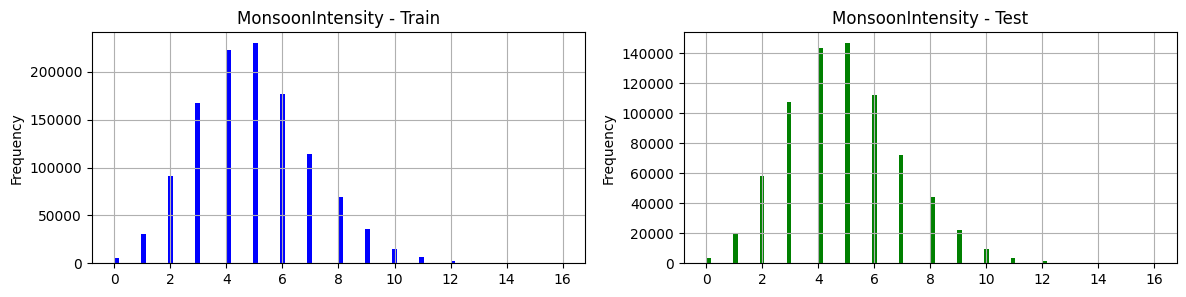

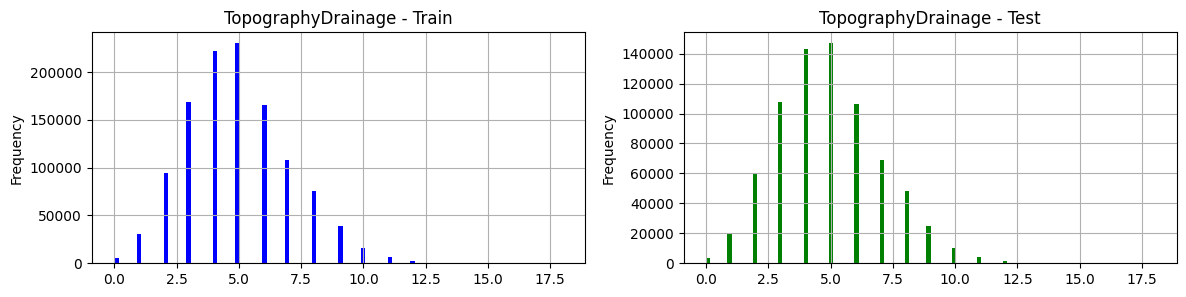

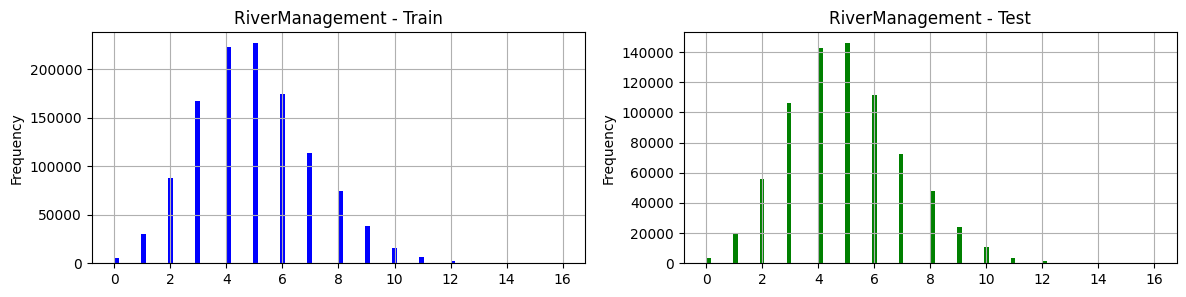

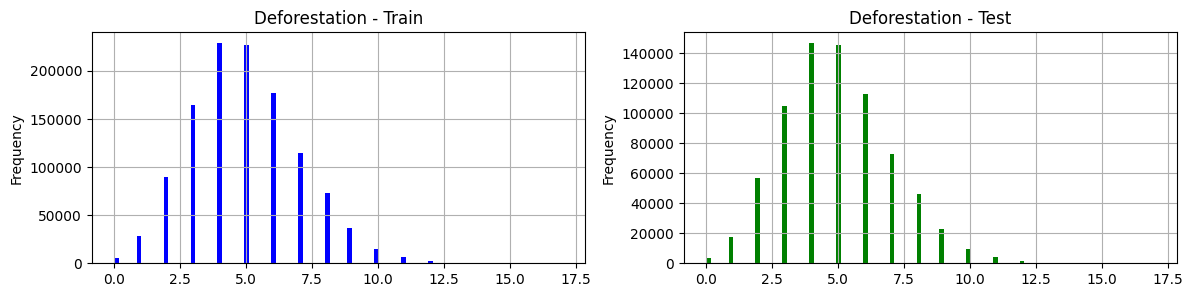

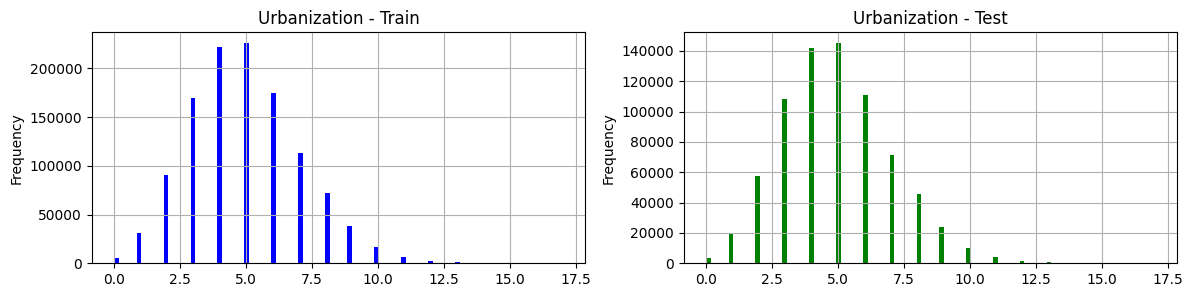

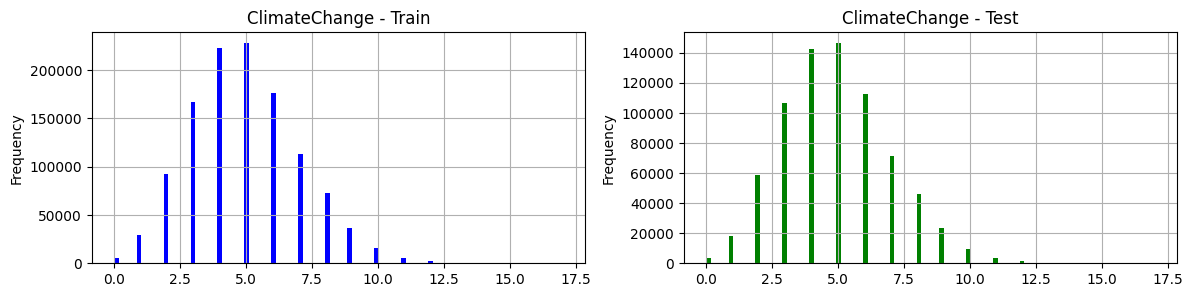

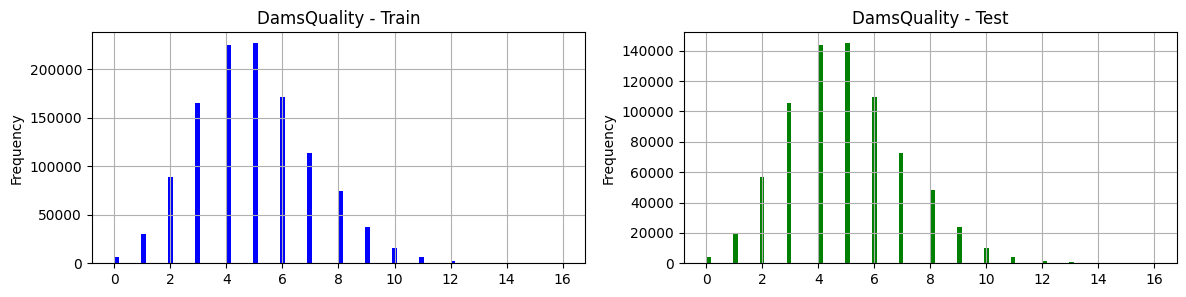

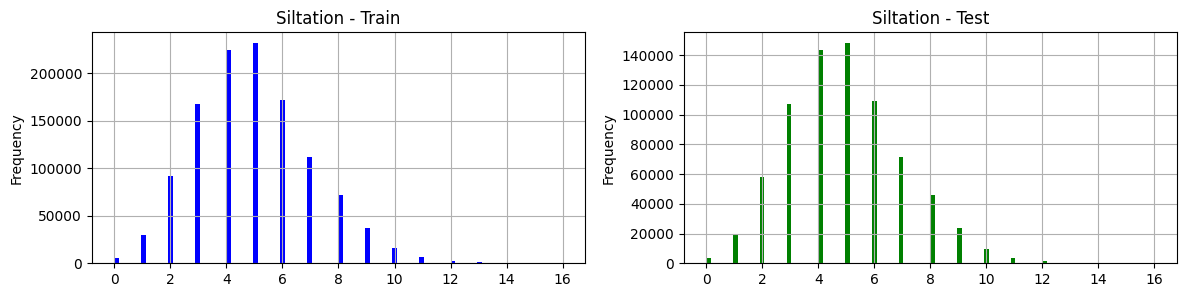

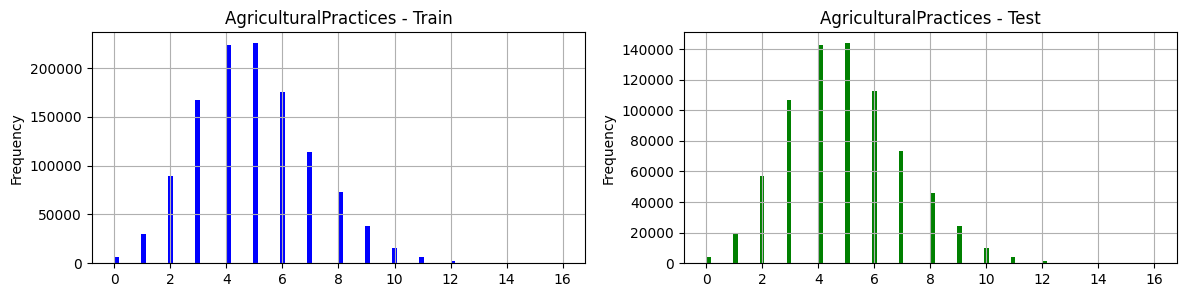

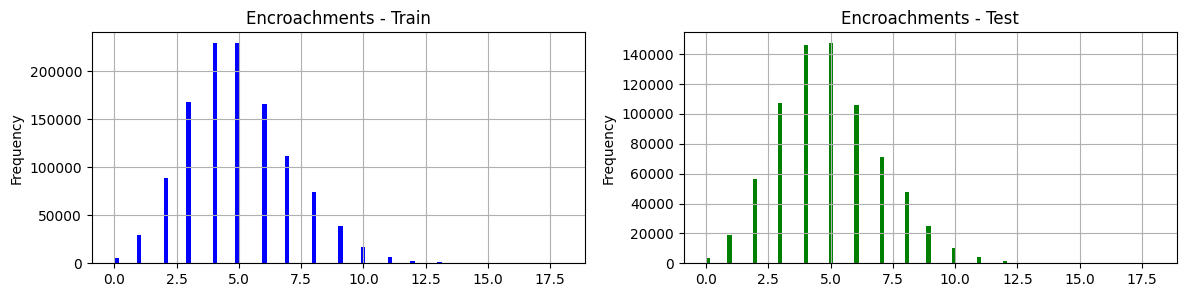

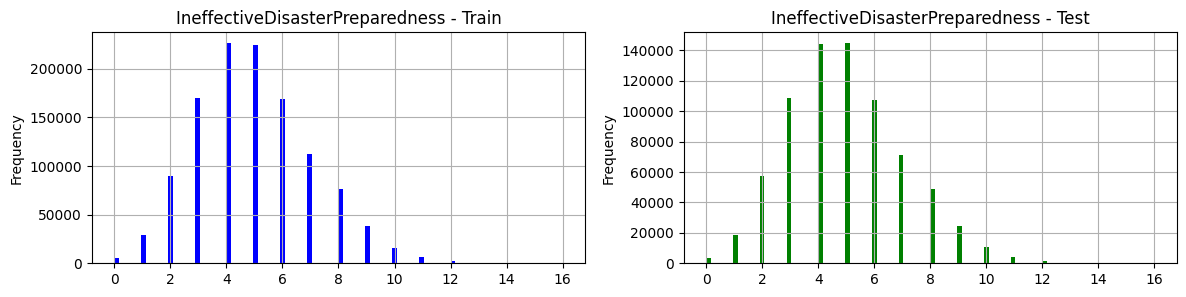

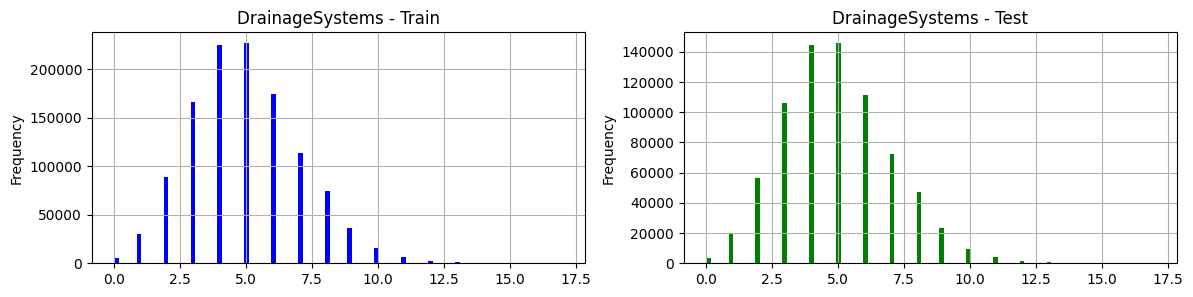

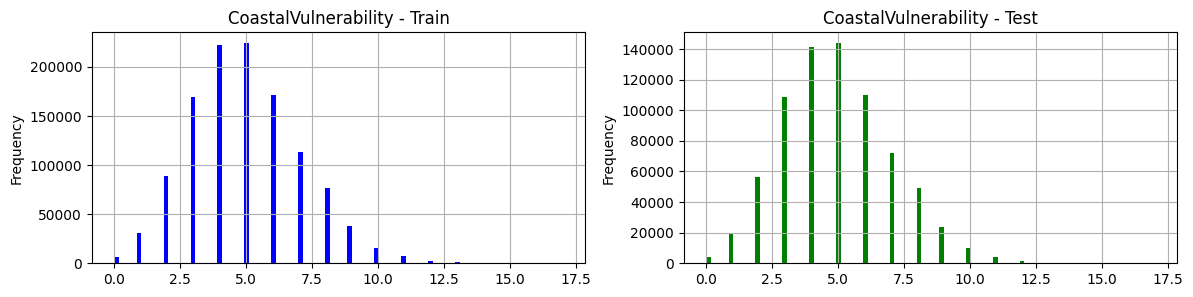

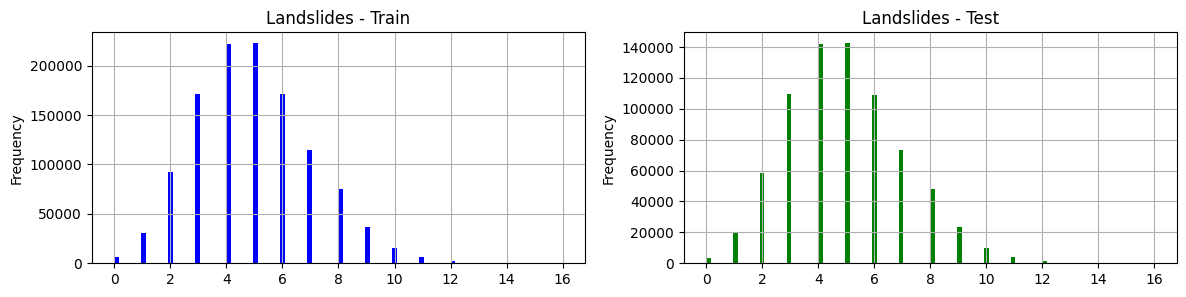

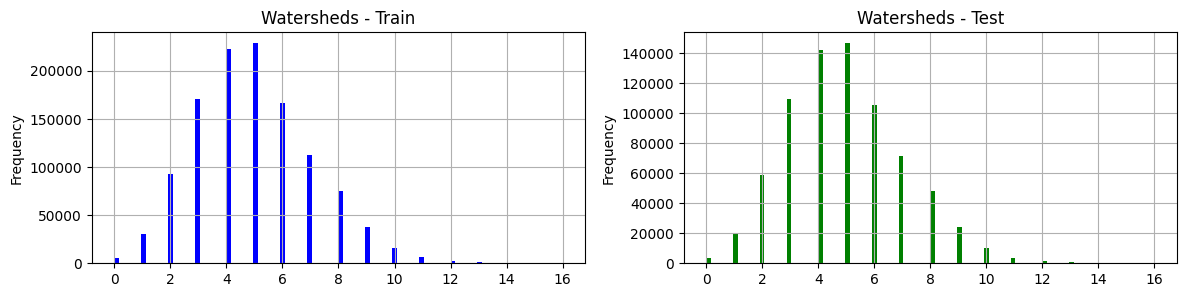

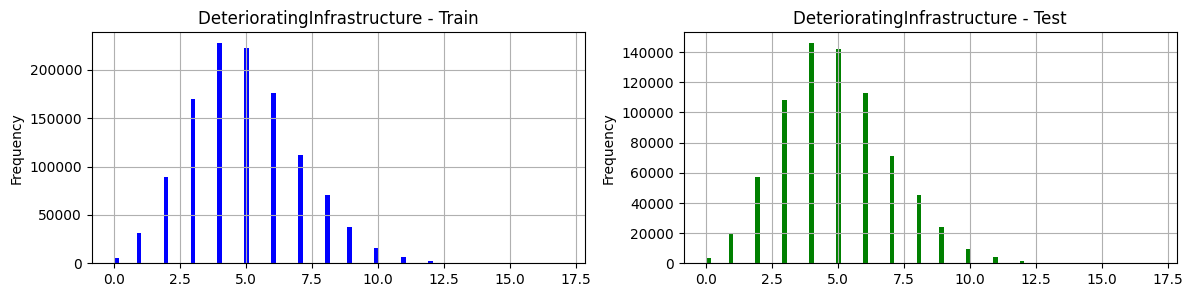

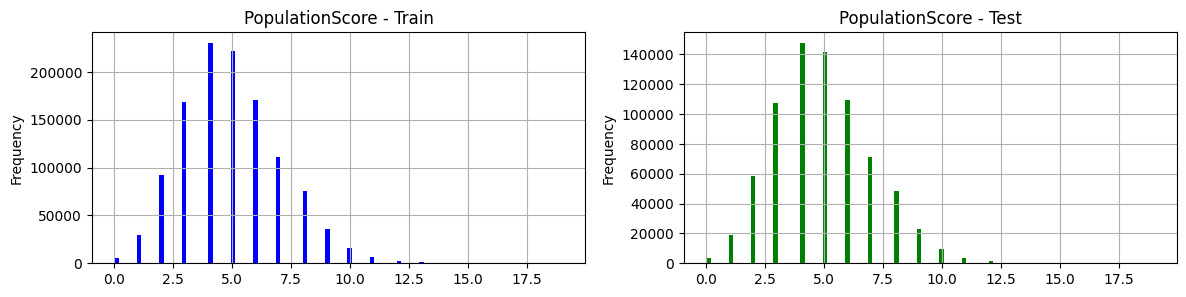

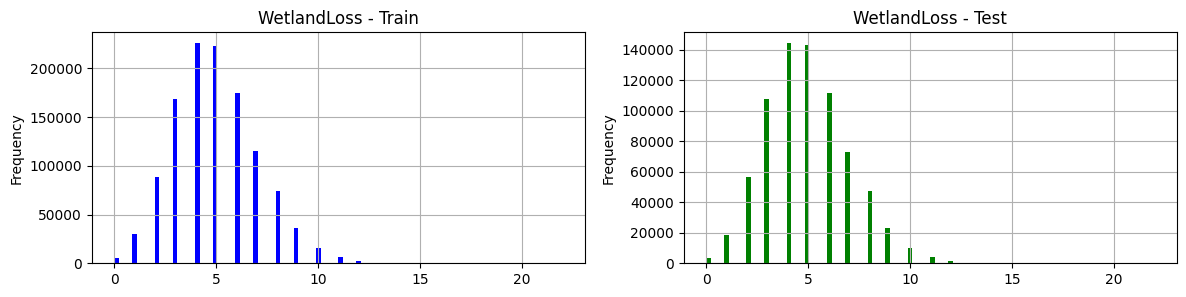

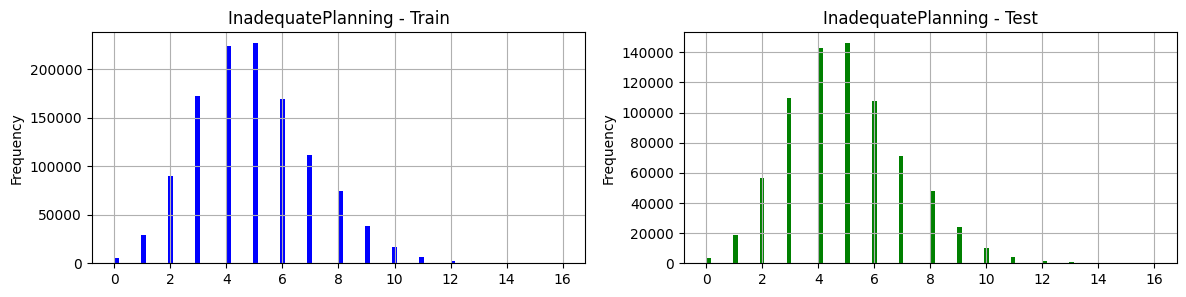

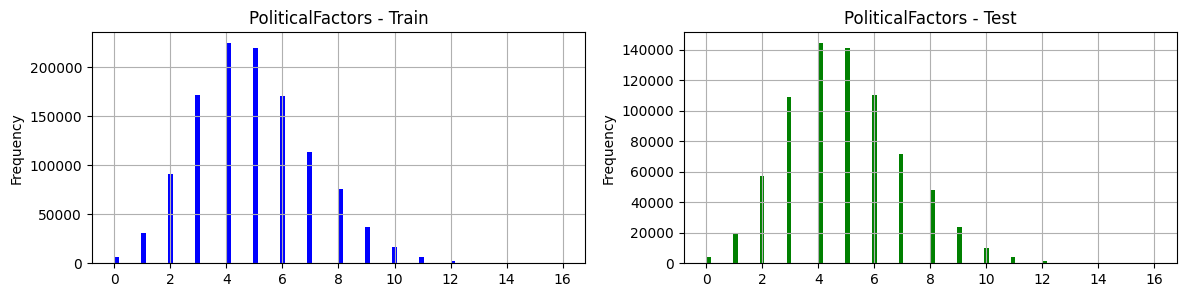

In [ ]:
for f in cat_features:
    plt.figure(figsize=(14,3))
    ax1 = plt.subplot(1,2,1)
    df_combined[f].plot(kind='hist', bins=100, color="blue")
    plt.title(f + ' - Train')
    plt.grid()
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    df_test[f].plot(kind='hist', bins=100, color="green")
    plt.title(f + ' - Test')
    plt.grid()
    plt.show()

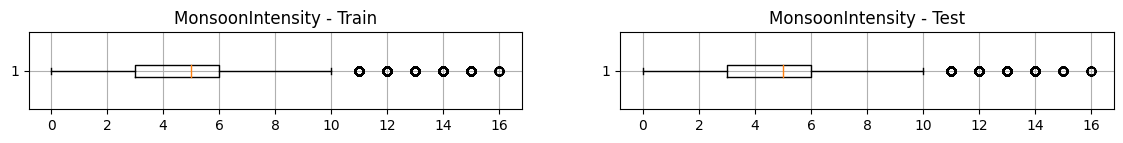

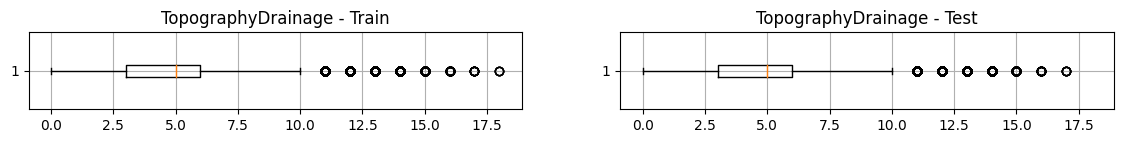

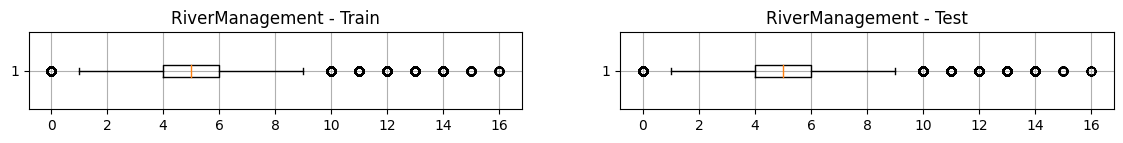

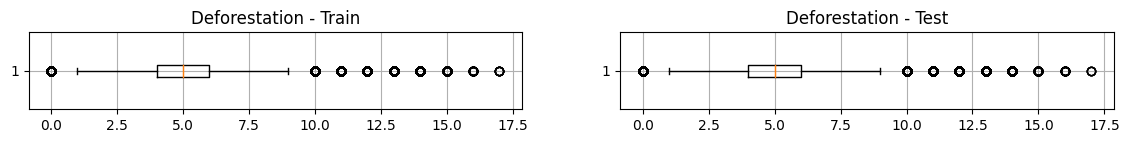

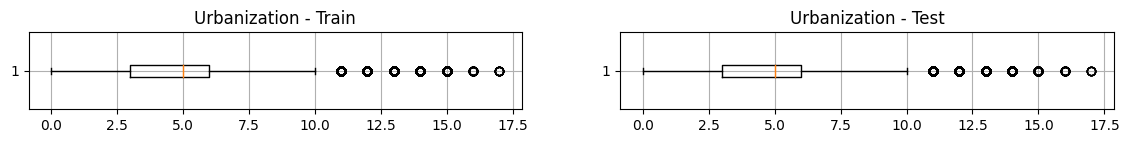

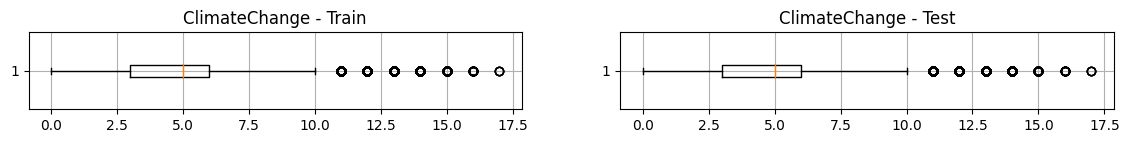

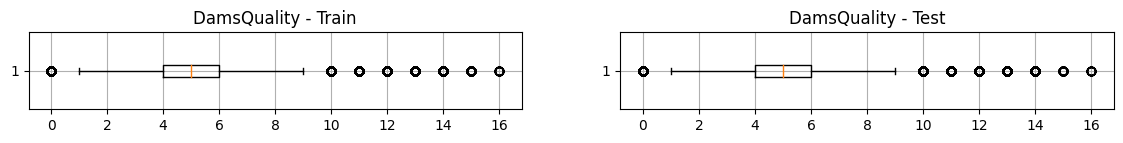

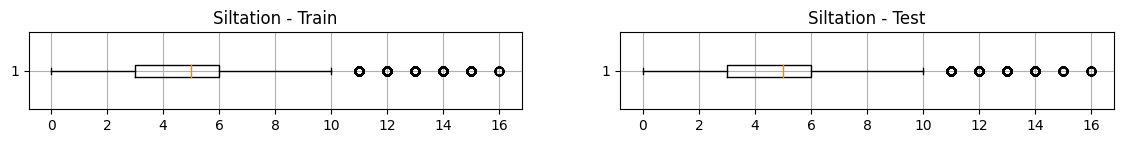

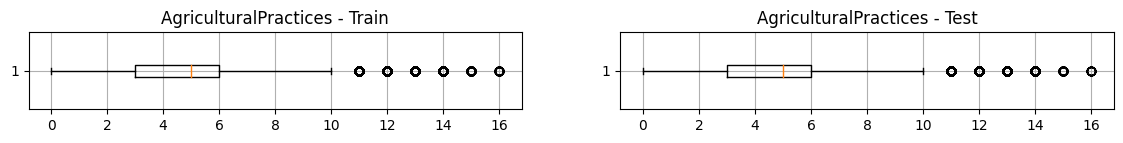

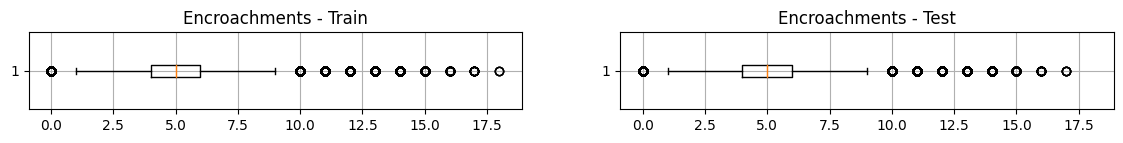

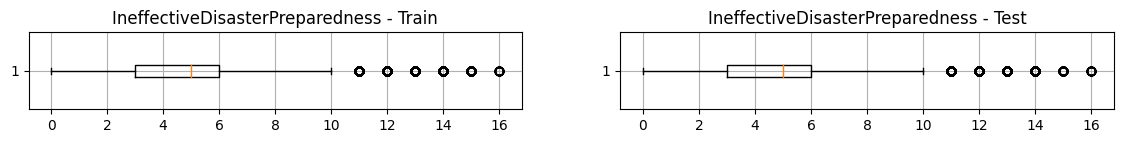

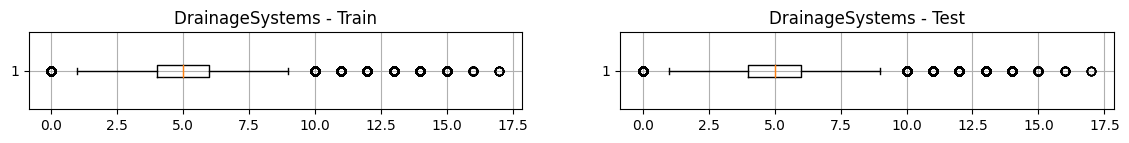

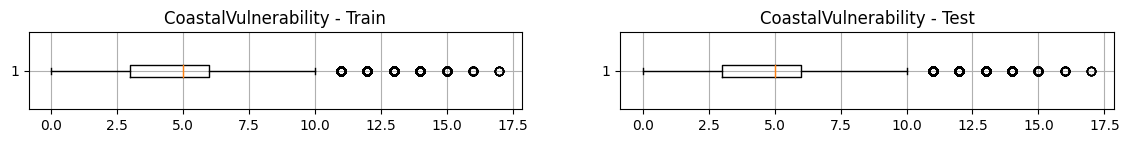

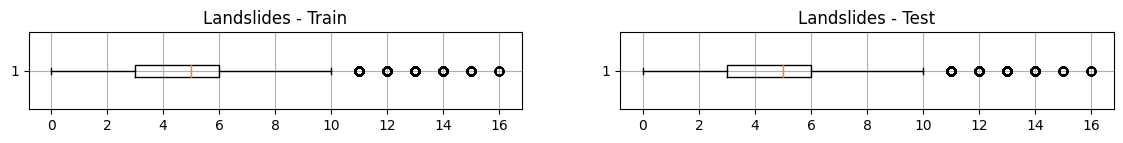

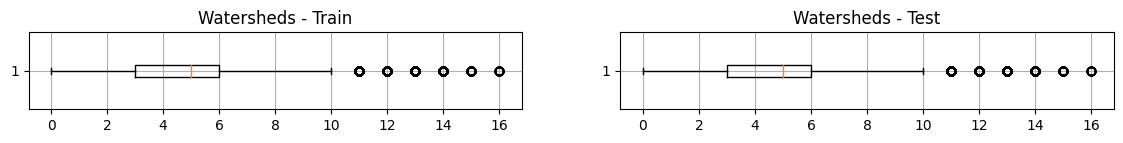

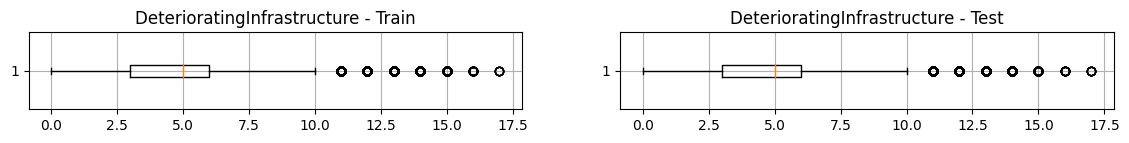

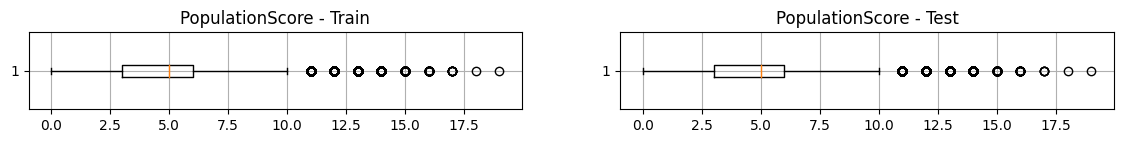

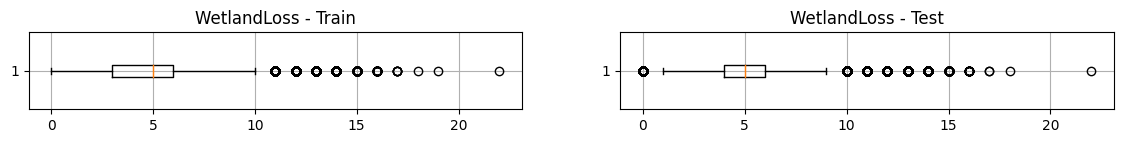

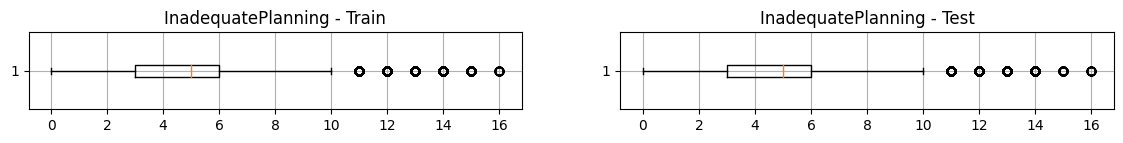

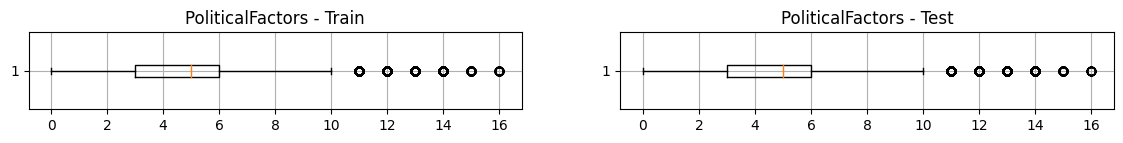

In [ ]:
for f in cat_features:
    plt.figure(figsize=(14,1))
    ax1 = plt.subplot(1,2,1)
    df_temp = df_combined[f].dropna()
    plt.boxplot(df_temp, vert=False)
    plt.title(f + ' - Train')
    plt.grid()
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    df_temp = df_test[f].dropna()
    plt.boxplot(df_temp, vert=False)
    plt.title(f + ' - Test')
    plt.grid()
    plt.show()

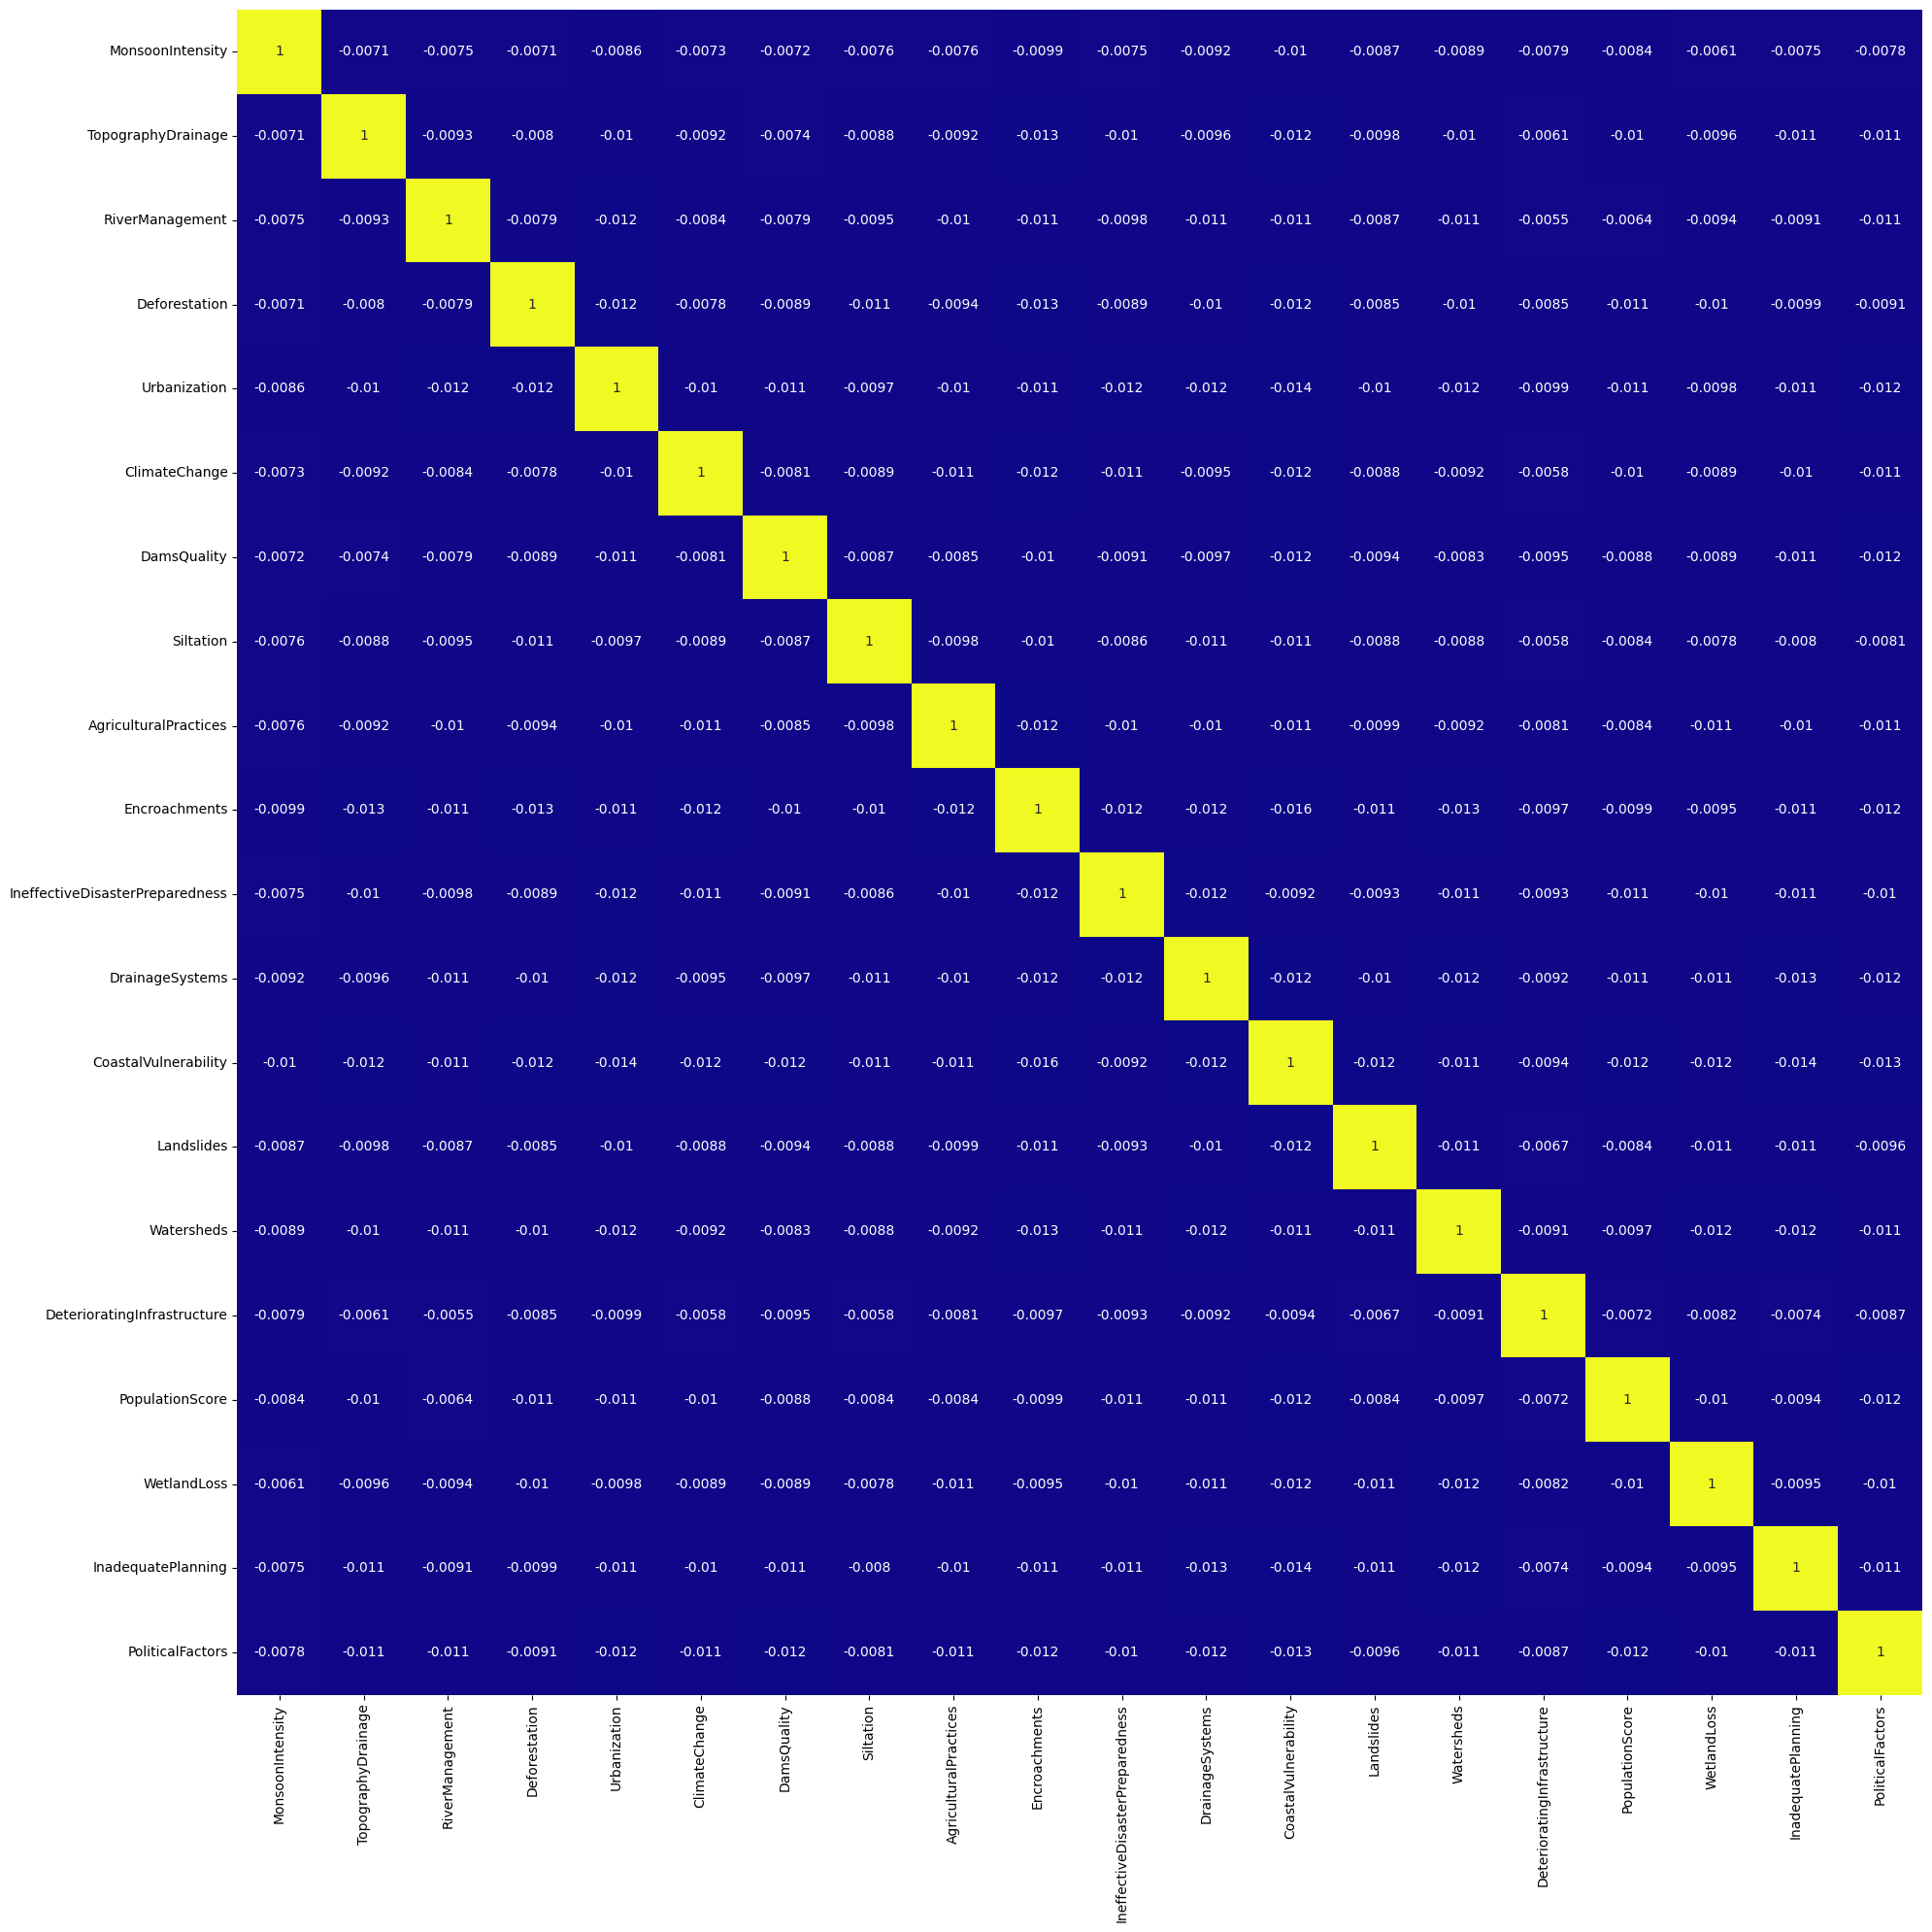

In [ ]:
plt.figure(figsize=(20,20))
corr_matrix = df_combined[cat_features].corr(method="pearson")
sns.heatmap(corr_matrix, annot=True,cmap="plasma", cbar=None)
plt.tight_layout()
plt.show()

In [8]:
target = "FloodProbability"
df_combined[["sum_of_all",target]].corr()

sum_of_all  FloodProbability
sum_of_all          1.000000          0.921277
FloodProbability    0.921277          1.000000

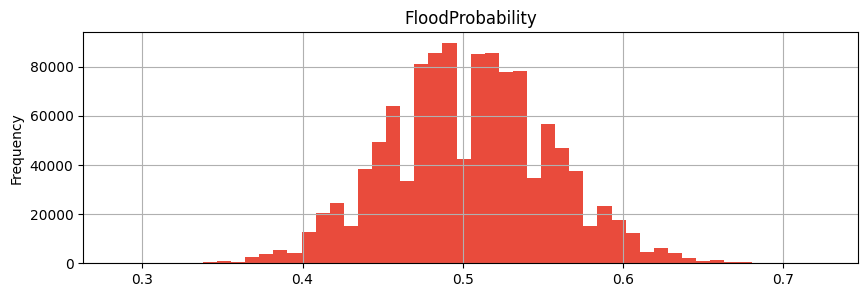

count    1.167957e+06
mean     5.042740e-01
std      5.099335e-02
min      2.850000e-01
25%      4.700000e-01
50%      5.050000e-01
75%      5.400000e-01
max      7.250000e-01
Name: FloodProbability, dtype: float64


In [ ]:
plt.figure(figsize=(10,3))
df_combined[target].plot(kind='hist', bins=50, color="#E94B3CFF")
plt.title(target)
plt.grid()
plt.show()
print(df_combined[target].describe().T)

In [ ]:
cat_features

['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors']

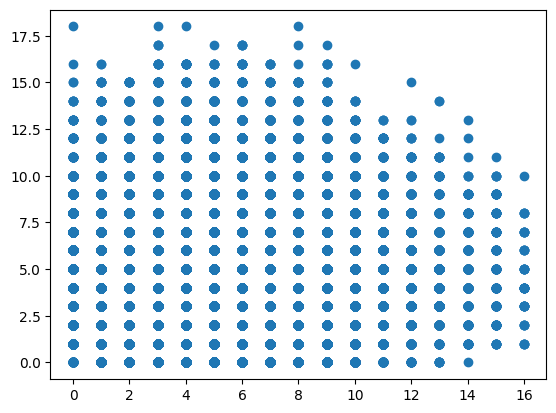

In [ ]:
plt.scatter(df_combined["MonsoonIntensity"], df_combined["TopographyDrainage"])
plt.show()

<Figure size 1400x300 with 0 Axes>

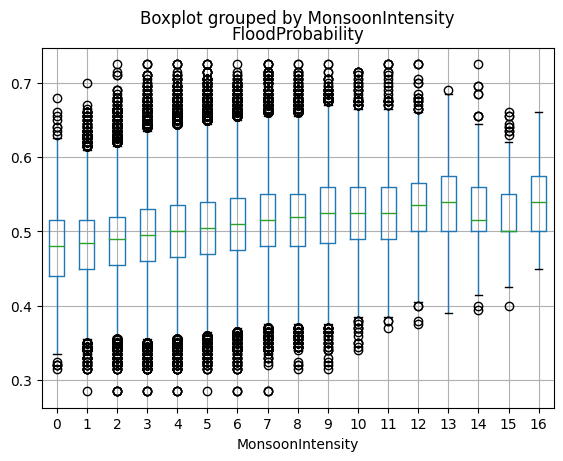

<Figure size 1400x300 with 0 Axes>

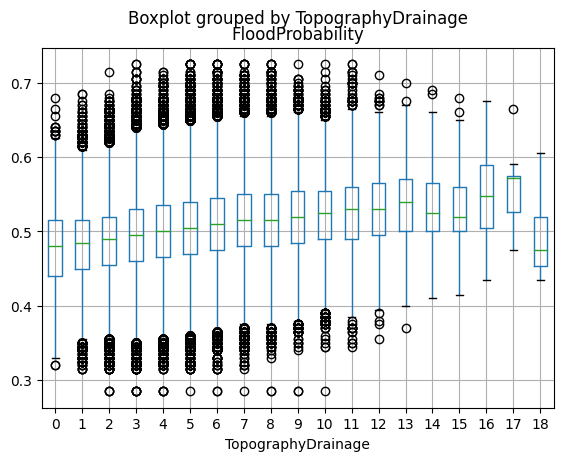

<Figure size 1400x300 with 0 Axes>

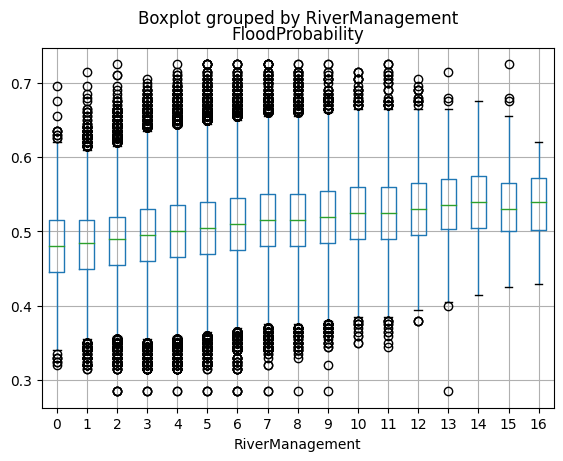

<Figure size 1400x300 with 0 Axes>

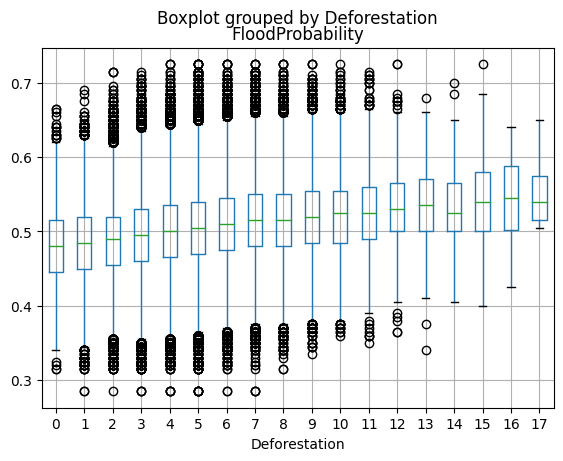

<Figure size 1400x300 with 0 Axes>

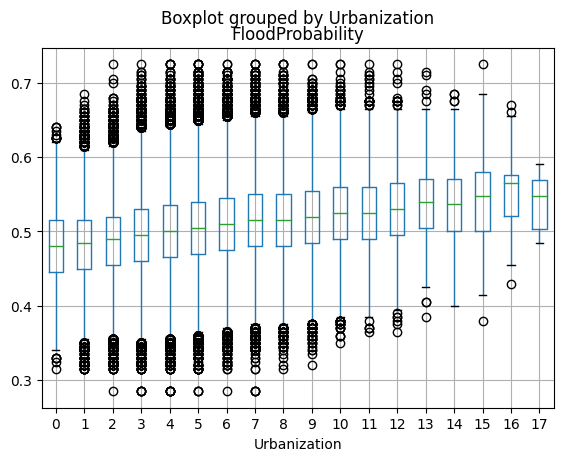

<Figure size 1400x300 with 0 Axes>

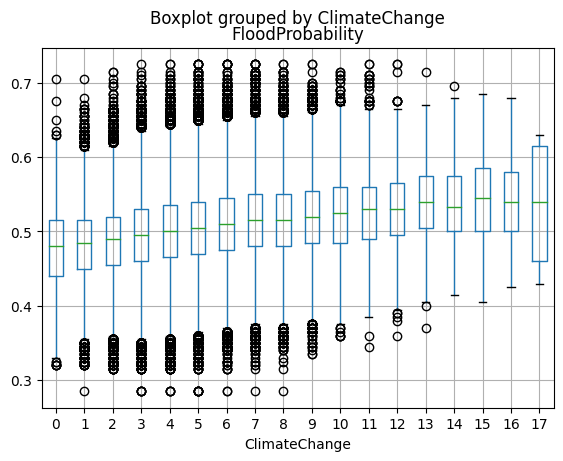

<Figure size 1400x300 with 0 Axes>

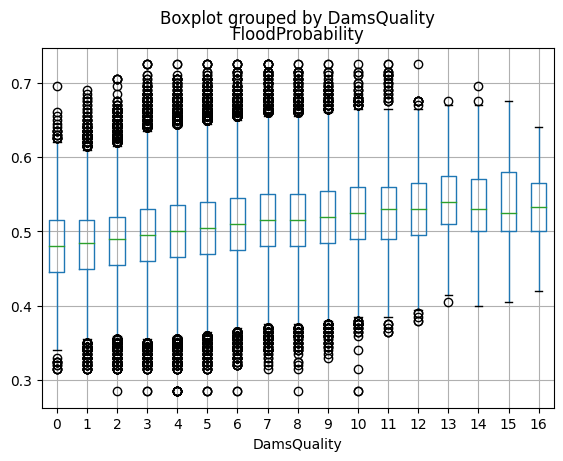

<Figure size 1400x300 with 0 Axes>

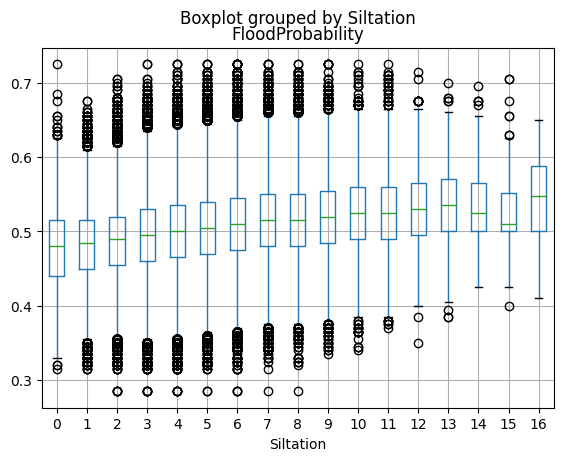

<Figure size 1400x300 with 0 Axes>

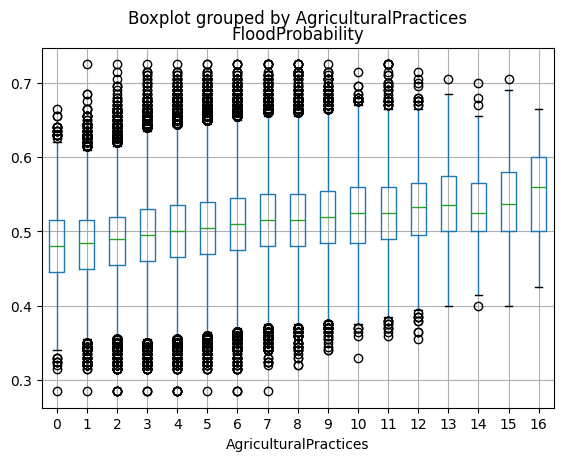

<Figure size 1400x300 with 0 Axes>

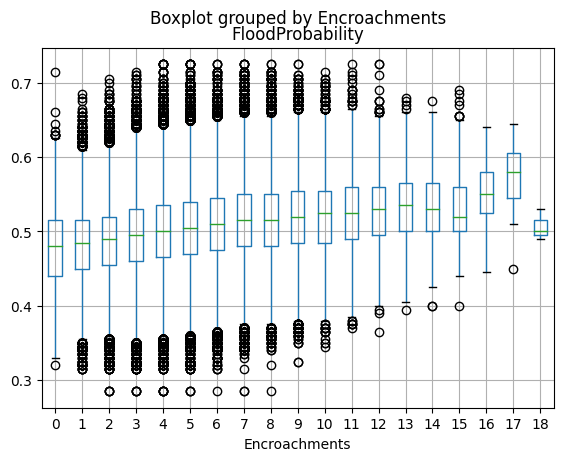

<Figure size 1400x300 with 0 Axes>

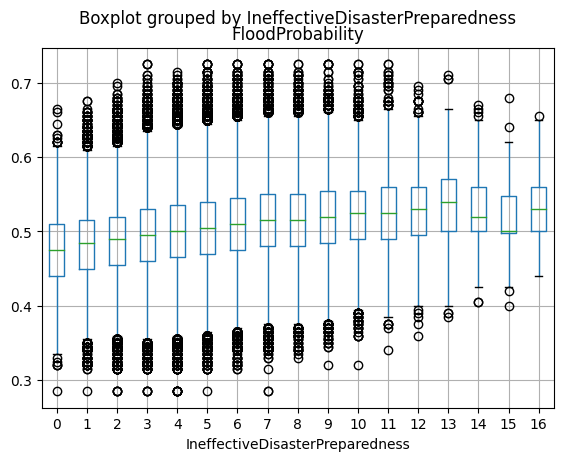

<Figure size 1400x300 with 0 Axes>

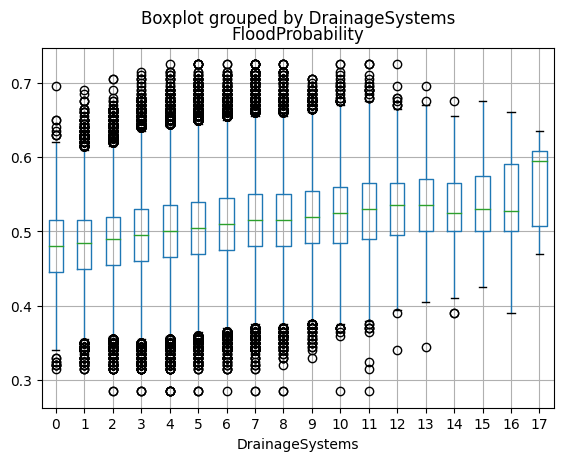

<Figure size 1400x300 with 0 Axes>

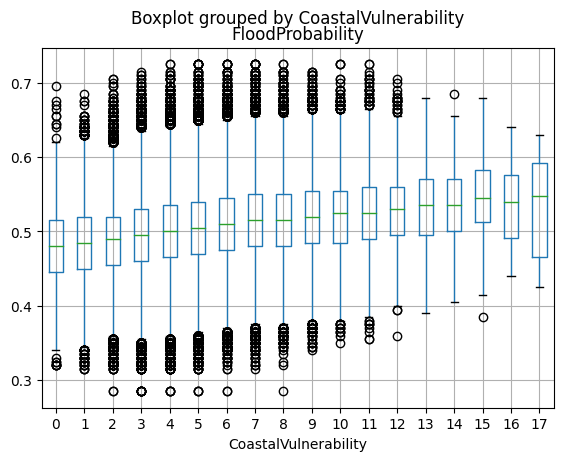

<Figure size 1400x300 with 0 Axes>

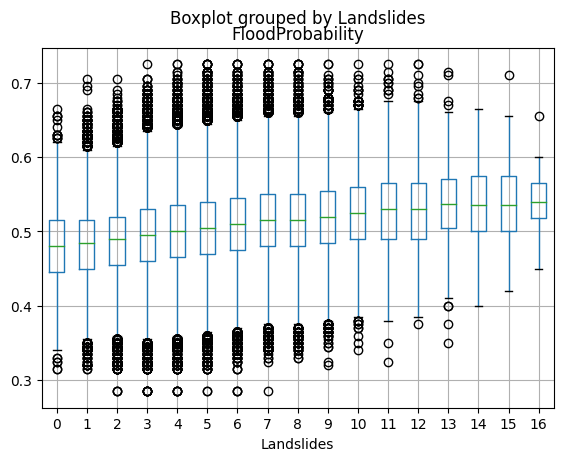

<Figure size 1400x300 with 0 Axes>

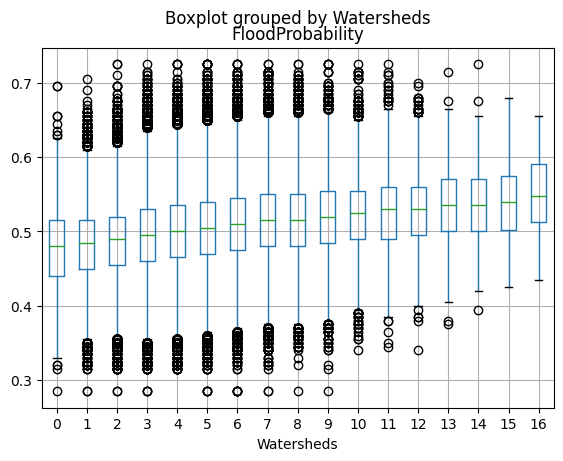

<Figure size 1400x300 with 0 Axes>

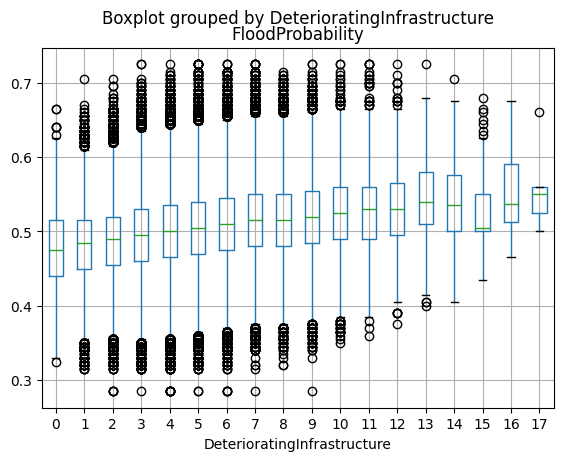

<Figure size 1400x300 with 0 Axes>

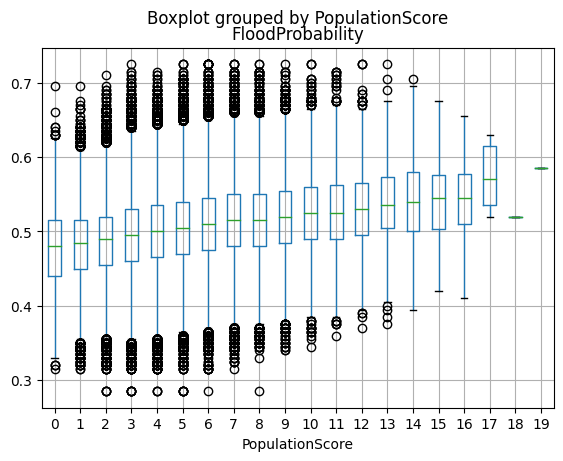

<Figure size 1400x300 with 0 Axes>

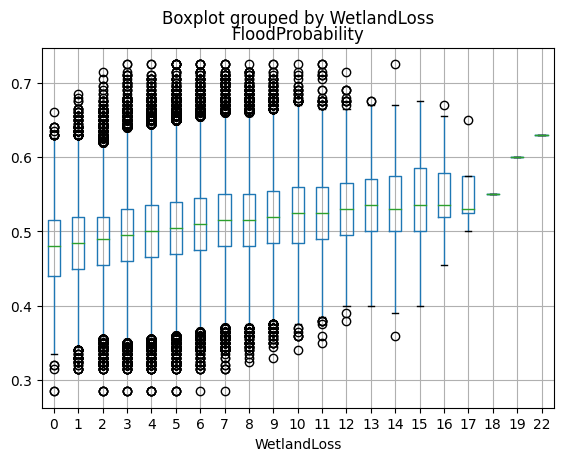

<Figure size 1400x300 with 0 Axes>

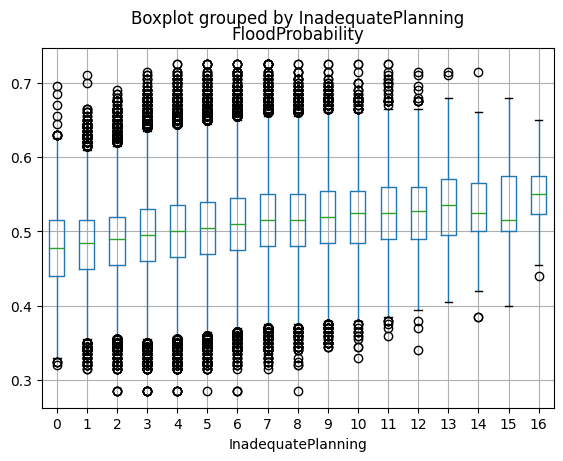

<Figure size 1400x300 with 0 Axes>

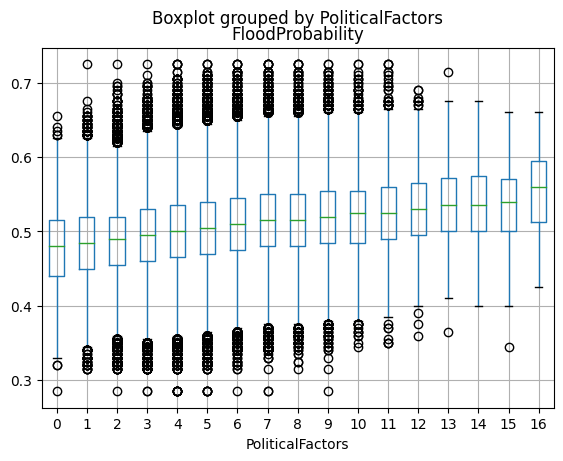

In [ ]:
for f in cat_features:
    plt.figure(figsize=(14,3))
    df_combined.boxplot(column = target, by = f)
    plt.show()

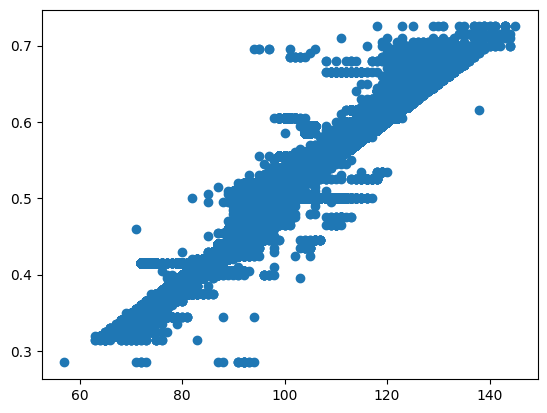

In [ ]:
plt.scatter(df_combined.sum_of_all, df_combined[target])
plt.show()

In [ ]:
num_feature = "sum_of_all"
cat_features.append(num_feature)

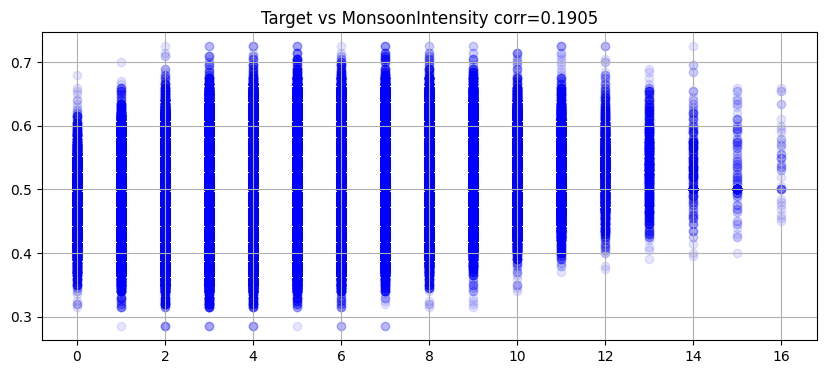

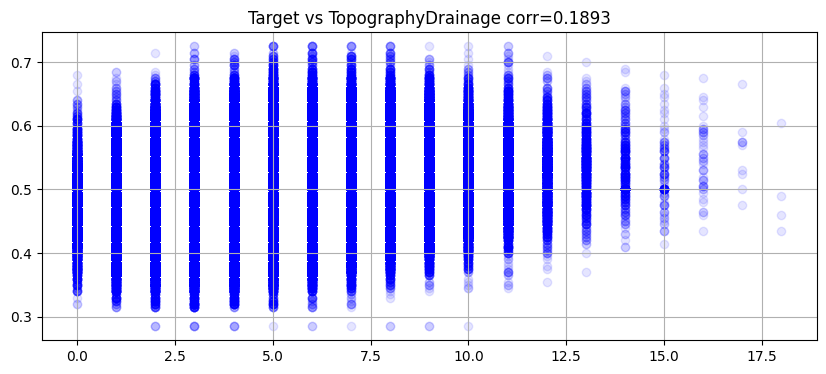

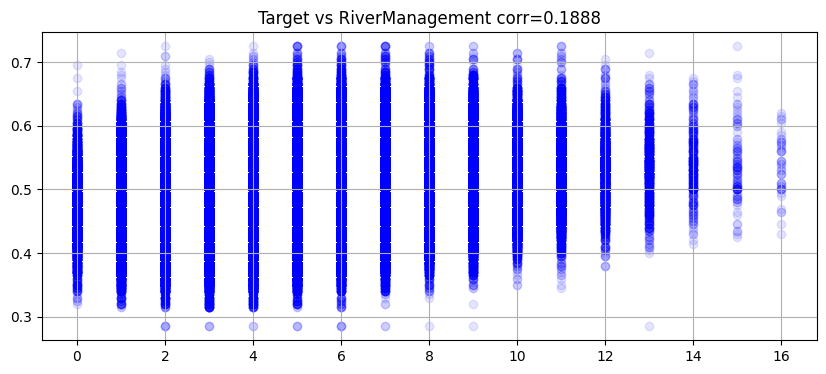

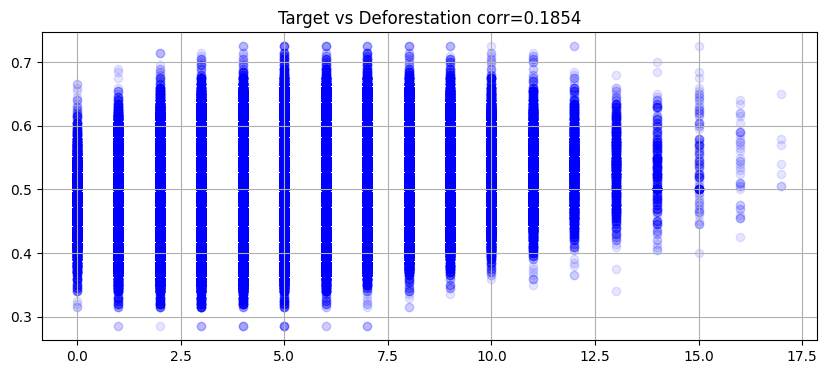

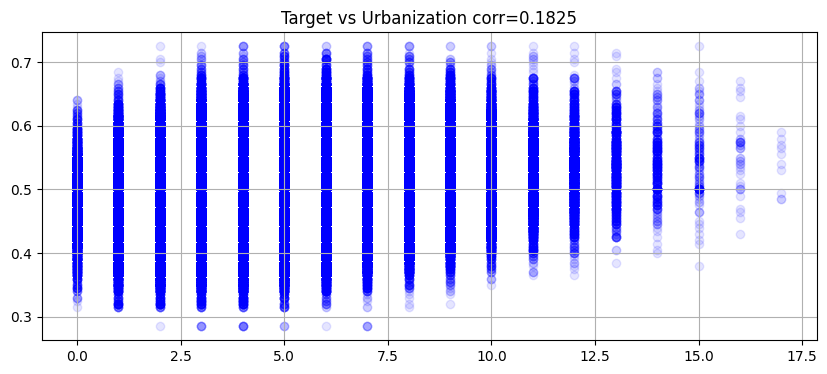

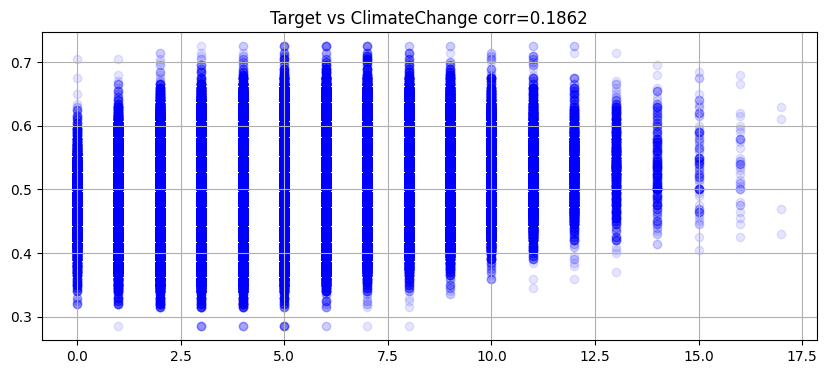

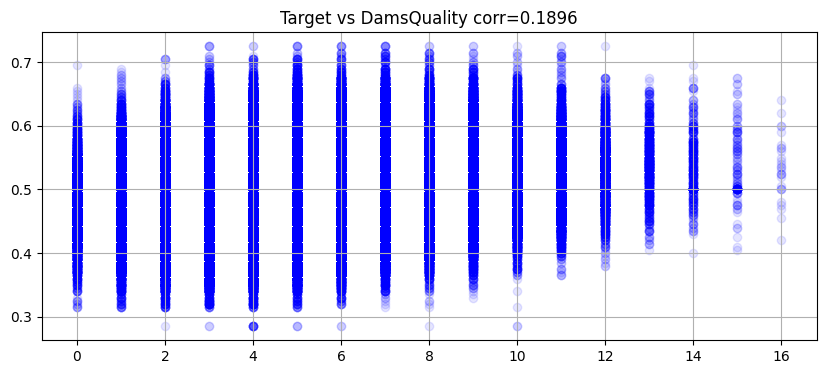

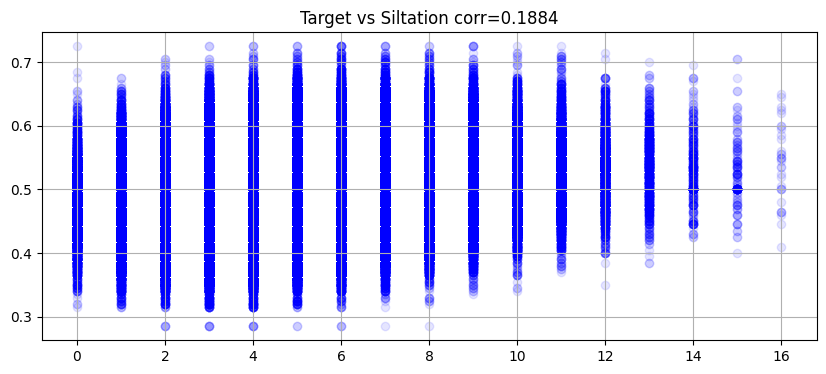

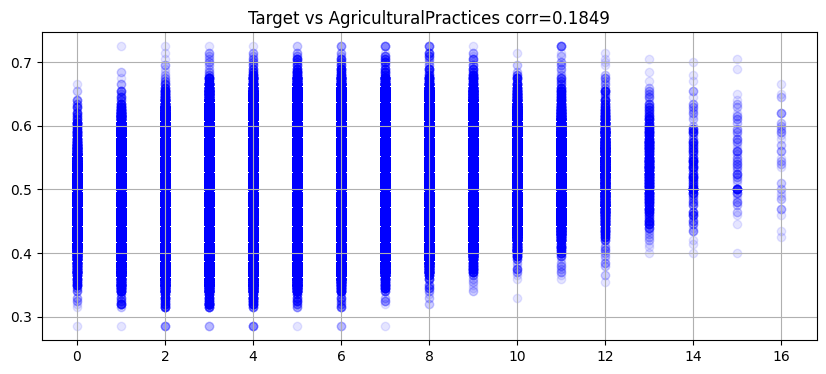

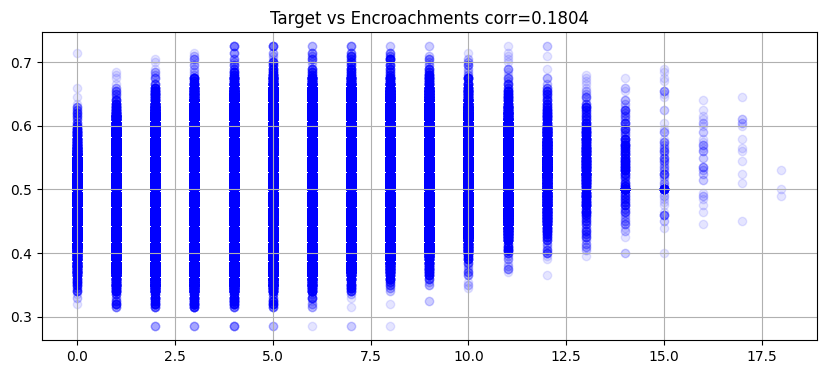

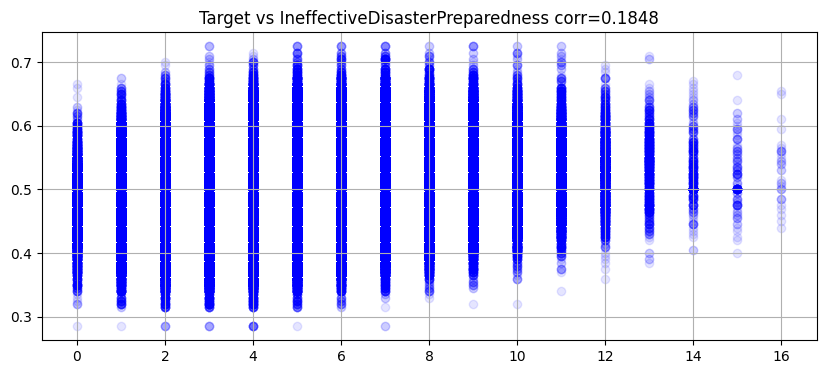

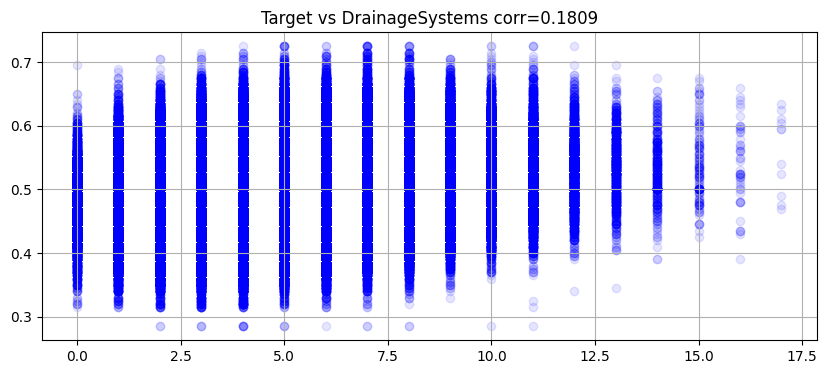

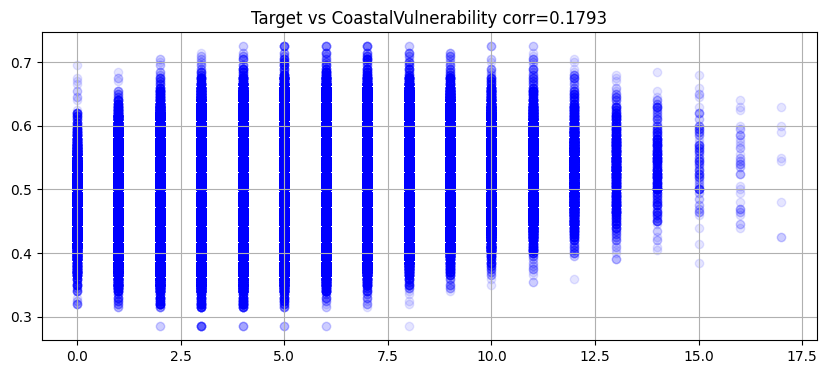

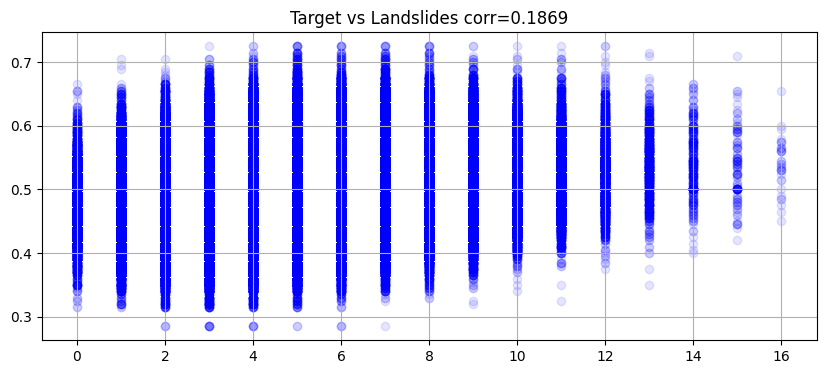

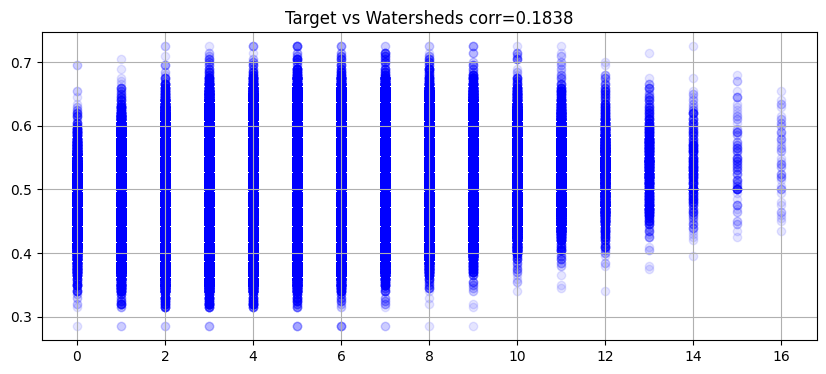

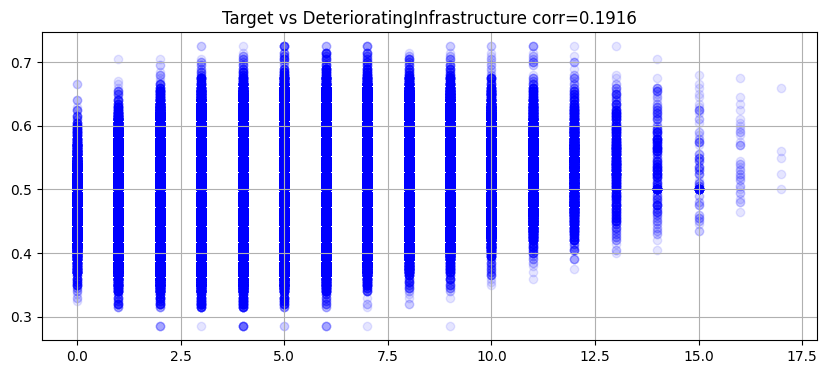

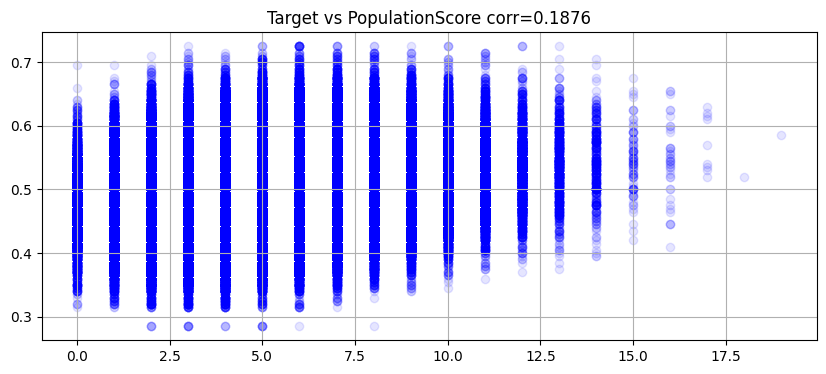

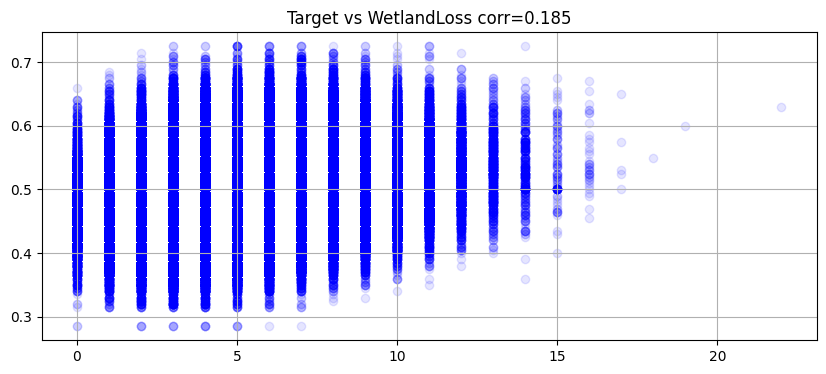

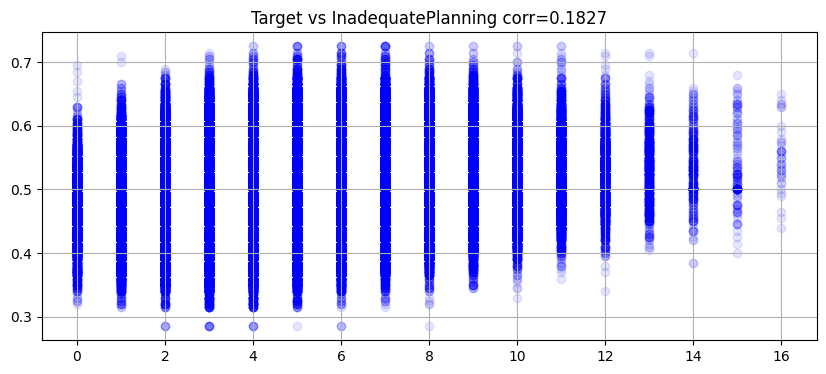

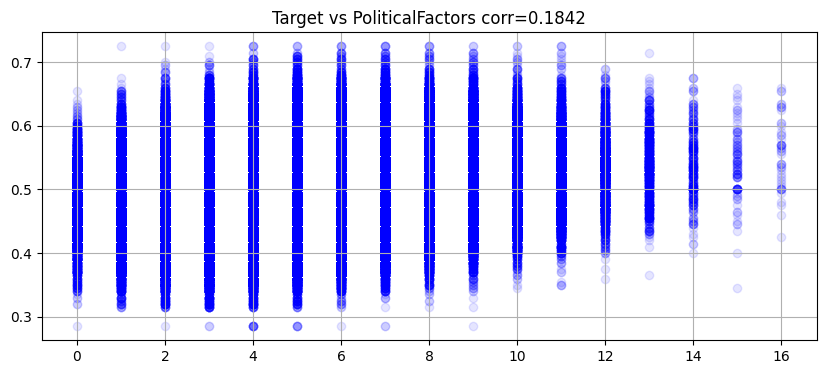

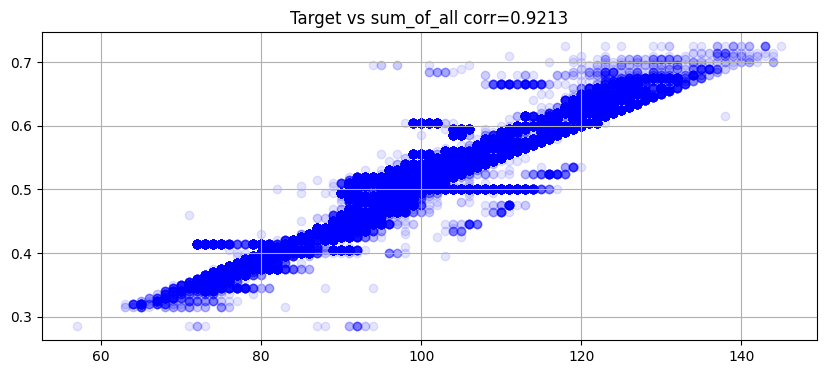

In [ ]:
for f in cat_features:
    if (f in cat_features):
        c = df_combined[target].corr(df_combined[f])
        plt.figure(figsize=(10,4))
        plt.scatter(df_combined[f], df_combined[target],color="blue", alpha=0.1)
        plt.title('Target vs ' + f + ' corr=' + str(np.round(c,4)))
        plt.grid()
        plt.show()
    else:
        plt.figure(figsize=(10,4))
        # pick only to most frequent levels
        most_freq = df_combined[f].value_counts().index[0:22].tolist()
        df_temp = df_combined[df_combined[f].isin(most_freq)]
        sns.violinplot(data=df_temp, x=f, y=target)
        plt.title('Target vs ' + f + ' (most frequent levels only)')
        plt.grid()
        plt.show()

In [ ]:
df_combined[target].corr(df_combined["sum_of_all"])

0.9212773137196445

In [9]:
# Split the train data into X and y
X = df_combined.drop(target, axis=1)
y = df_combined.FloodProbability

In [10]:
%%time
# Running non tuned cat boost model to get feature importance
base_cat = CatBoostRegressor(random_state=27, task_type='GPU')
base_cat.fit(X, y)

Learning rate set to 0.101893
0:	learn: 0.0467161	total: 48.7ms	remaining: 48.6s
1:	learn: 0.0429019	total: 80.7ms	remaining: 40.3s
2:	learn: 0.0395383	total: 111ms	remaining: 36.9s
3:	learn: 0.0365929	total: 138ms	remaining: 34.5s
4:	learn: 0.0340014	total: 164ms	remaining: 32.6s
5:	learn: 0.0317507	total: 191ms	remaining: 31.6s
6:	learn: 0.0297737	total: 217ms	remaining: 30.8s
7:	learn: 0.0280699	total: 242ms	remaining: 30.1s
8:	learn: 0.0265870	total: 269ms	remaining: 29.6s
9:	learn: 0.0253315	total: 294ms	remaining: 29.1s
10:	learn: 0.0242480	total: 320ms	remaining: 28.7s
11:	learn: 0.0233384	total: 344ms	remaining: 28.3s
12:	learn: 0.0225650	total: 369ms	remaining: 28s
13:	learn: 0.0219058	total: 393ms	remaining: 27.7s
14:	learn: 0.0213547	total: 418ms	remaining: 27.4s
15:	learn: 0.0208928	total: 442ms	remaining: 27.2s
16:	learn: 0.0205091	total: 466ms	remaining: 27s
17:	learn: 0.0201893	total: 491ms	remaining: 26.8s
18:	learn: 0.0199224	total: 515ms	remaining: 26.6s
19:	learn: 0.

In [11]:
predictions = base_cat.predict(X)
r2 = np.sqrt(r2_score(y, predictions))
print(f"Base Model R^2 score: {r2:.8f}")

Base Model R^2 score: 0.93381690


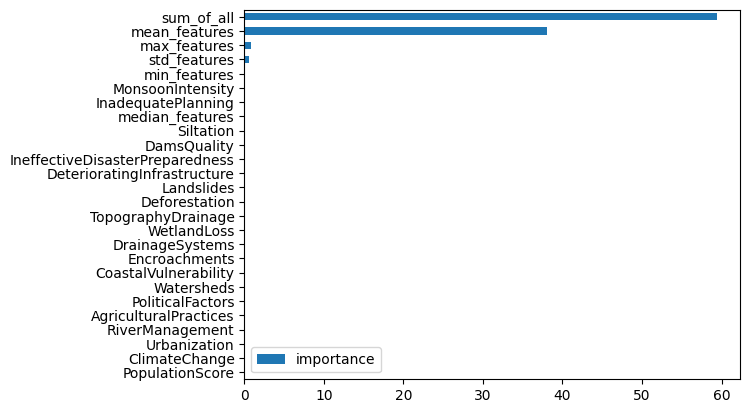

In [12]:
importance = base_cat.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']).sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh')
plt.show()

In [13]:
df_test.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'mean_features',
       'std_features', 'max_features', 'min_features', 'median_features',
       'sum_of_all'],
      dtype='object')

In [15]:
X = X.drop(cat_features, axis=1)
df_test = df_test.drop(cat_features, axis=1)

# Scaling the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

df_test_scaled = scaler.transform(df_test)


In [17]:
%%time
def objective(trial):
    model = CatBoostRegressor(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        # colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
        depth=trial.suggest_int("depth", 2, 16),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        verbose=False,
        random_state=27,
        task_type='GPU'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(r2_score(y_test, y_pred))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=27)

In [19]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=27)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")

for key, value in trial.params.items():
    print(f"    {key}: {value}")
# print("*"*100)

Number of finished trials:  20
Best trial:
 Value:  0.933587960261081
 Params: 
    iterations: 924
    learning_rate: 0.02565502967913866
    min_data_in_leaf: 39
    depth: 12
    l2_leaf_reg: 17.10454655447745
CPU times: user 17min 59s, sys: 2min 35s, total: 20min 34s
Wall time: 15min 9s


In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=27)

In [24]:
"""(
    iterations: 924
    learning_rate: 0.02565502967913866
    min_data_in_leaf: 39
    depth: 12
    l2_leaf_reg: 17.10454655447745
    )"""

rev_model = CatBoostRegressor(
    task_type = "GPU",
    iterations = 924,
    learning_rate = 0.02565502967913866,
    min_data_in_leaf = 39,
    depth = 12,
    l2_leaf_reg = 17.10454655447745
    )

rev_model.fit(X_train, y_train)

0:	learn: 0.0498746	total: 50.4ms	remaining: 46.5s
1:	learn: 0.0487933	total: 104ms	remaining: 48s
2:	learn: 0.0477415	total: 156ms	remaining: 47.8s
3:	learn: 0.0467195	total: 212ms	remaining: 48.7s
4:	learn: 0.0457291	total: 265ms	remaining: 48.7s
5:	learn: 0.0447679	total: 318ms	remaining: 48.7s
6:	learn: 0.0438344	total: 369ms	remaining: 48.4s
7:	learn: 0.0429299	total: 419ms	remaining: 48s
8:	learn: 0.0420529	total: 468ms	remaining: 47.6s
9:	learn: 0.0412020	total: 519ms	remaining: 47.5s
10:	learn: 0.0403774	total: 567ms	remaining: 47.1s
11:	learn: 0.0395773	total: 614ms	remaining: 46.6s
12:	learn: 0.0387989	total: 661ms	remaining: 46.4s
13:	learn: 0.0380479	total: 709ms	remaining: 46.1s
14:	learn: 0.0373181	total: 757ms	remaining: 45.9s
15:	learn: 0.0366109	total: 806ms	remaining: 45.7s
16:	learn: 0.0359271	total: 853ms	remaining: 45.5s
17:	learn: 0.0352685	total: 902ms	remaining: 45.4s
18:	learn: 0.0346295	total: 950ms	remaining: 45.3s
19:	learn: 0.0340107	total: 1000ms	remaining

In [27]:
rev_pred = rev_model.predict(X_val)

In [29]:
r2_rev = np.sqrt(r2_score(y_val, rev_pred))
print(f"Model 1 R^2 score: {r2_rev:.8f}")

Model 1 R^2 score: 0.93358363


In [31]:
y_pred_test = rev_model.predict(df_test_scaled)
y_pred_test[:10]

array([0.57785609, 0.45469676, 0.44953565, 0.4672113 , 0.46691008,
       0.50751647, 0.53676287, 0.52660871, 0.47404098, 0.57581369])

In [ ]:
submission = pd.DataFrame({
    'id': df_test_id,
    'FloodProbability': y_pred_test
})

submission.to_csv('Pranit_S4E5_submission_feature_engg.csv', index=False)
submission.head(10)

In [ ]:
'''Model 1
(
    iterations=716,
    learning_rate=0.09423155164094112,
    min_data_in_leaf=3,
    depth=10,
    l2_leaf_reg=0.009906225212904752,
)'''


'''
Model 2
(
    iterations=716,
    learning_rate=0.09423155164094112,
    colsample_bylevel=0.32374524982071545,
    min_data_in_leaf=3,
    depth=10,
    l2_leaf_reg=0.009906225212904752,
)'''

In [ ]:
model1 = CatBoostRegressor(
    iterations=716,
    learning_rate=0.09423155164094112,
    min_data_in_leaf=3,
    depth=10,
    l2_leaf_reg=0.009906225212904752,
)

model2 = CatBoostRegressor(
    iterations=716,
    learning_rate=0.09423155164094112,
    colsample_bylevel=0.32374524982071545,
    min_data_in_leaf=3,
    depth=10,
    l2_leaf_reg=0.009906225212904752,
)

In [ ]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

0:	learn: 0.0469603	total: 135ms	remaining: 1m 36s
1:	learn: 0.0433713	total: 269ms	remaining: 1m 35s
2:	learn: 0.0401298	total: 415ms	remaining: 1m 38s
3:	learn: 0.0372945	total: 551ms	remaining: 1m 38s
4:	learn: 0.0347706	total: 746ms	remaining: 1m 46s
5:	learn: 0.0325334	total: 921ms	remaining: 1m 48s
6:	learn: 0.0305759	total: 1.14s	remaining: 1m 55s
7:	learn: 0.0288685	total: 1.3s	remaining: 1m 54s
8:	learn: 0.0273946	total: 1.44s	remaining: 1m 53s
9:	learn: 0.0260887	total: 1.58s	remaining: 1m 51s
10:	learn: 0.0249509	total: 1.74s	remaining: 1m 51s
11:	learn: 0.0239704	total: 1.87s	remaining: 1m 49s
12:	learn: 0.0231304	total: 2.03s	remaining: 1m 49s
13:	learn: 0.0224220	total: 2.17s	remaining: 1m 48s
14:	learn: 0.0218241	total: 2.4s	remaining: 1m 52s
15:	learn: 0.0213069	total: 2.54s	remaining: 1m 50s
16:	learn: 0.0208685	total: 2.68s	remaining: 1m 50s
17:	learn: 0.0204978	total: 2.85s	remaining: 1m 50s
18:	learn: 0.0202005	total: 3s	remaining: 1m 50s
19:	learn: 0.0199449	total:

In [ ]:
pred1 = model1.predict(X_val)
pred2 = model2.predict(X_val)

r2_m1 = np.sqrt(r2_score(y_val, pred1))
r2_m2 = np.sqrt(r2_score(y_val, pred2))

print(f"Model 1 R^2 score: {r2_m1:.8f}")
print(f"Model 2 R^2 score: {r2_m2:.8f}")

Model 1 R^2 score: 0.93271594
Model 2 R^2 score: 0.93260022


In [ ]:
y_pred_test = model1.predict(df_test)
y_pred_test[:10]

array([0.57664108, 0.45153621, 0.44953298, 0.47135638, 0.47036068,
       0.50636929, 0.53734296, 0.52652562, 0.47214272, 0.57439955])

In [ ]:
submission = pd.DataFrame({
    'id': df_test_id,
    'FloodProbability': y_pred_test
})

submission.to_csv('Pranit_S4E5_submission_feature_engg.csv', index=False)
submission.head(10)

id  FloodProbability
0  1117957          0.576641
1  1117958          0.451536
2  1117959          0.449533
3  1117960          0.471356
4  1117961          0.470361
5  1117962          0.506369
6  1117963          0.537343
7  1117964          0.526526
8  1117965          0.472143
9  1117966          0.574400

In [ ]:
# Scaling the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

df_test_scaled = scaler.transform(df_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=27)

In [ ]:
# Base XGB Model
xgb_base = XGBRegressor(tree_method = "gpu_hist")
xgb_base.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
pred_train = xgb_base.predict(X_train)
pred_test = xgb_base.predict(X_val)

In [ ]:
r2_train = np.sqrt(r2_score(y_train, pred_train))
r2_test = np.sqrt(r2_score(y_val, pred_test))

In [ ]:
r2_train, r2_test

(0.9337205386417133, 0.9326648126107259)

In [ ]:
y_pred_test = xgb_base.predict(df_test_scaled)
y_pred_test[:10]

array([0.57654333, 0.4513493 , 0.4487595 , 0.47132427, 0.4709551 ,
       0.5064085 , 0.5369684 , 0.5275077 , 0.47298798, 0.57561845],
      dtype=float32)

In [32]:
submission = pd.DataFrame({
    'id': df_test_id,
    'FloodProbability': y_pred_test
})

submission.to_csv('S4E5_submission_feature_engg_CB.csv', index=False)
submission.head(10)

id  FloodProbability
0  1117957          0.577856
1  1117958          0.454697
2  1117959          0.449536
3  1117960          0.467211
4  1117961          0.466910
5  1117962          0.507516
6  1117963          0.536763
7  1117964          0.526609
8  1117965          0.474041
9  1117966          0.575814

In [ ]:
# BUilding an XGB Model with tuning using optuna
%%time
def objective_xbg(trial):

    param = {
        "verbosity": 10,
        "objective": "reg:squarederror",
        # use exact for small df.
        "tree_method": "gpu_hist",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

In [ ]:
scaler =